In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from bp import data_gather_from_files,run_strategy_optimised,run_strategy_eval,tick_to_ohlc,get_date_pairs
import seaborn as sns
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.optimize import brute,fmin

In [2]:
tick_data = data_gather_from_files('1 jan 2021','31 jul 2021')['EURUSD.mid']

In [3]:
pd.set_option('display.float_format', '{:.5f}'.format)

## Optuna

In [4]:
import optuna 

In [5]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [7]:
time1 = time.time()

def objective_optuna(trial, tick_data):
    G = trial.suggest_int("G", 1, 10)*0.001
    n = trial.suggest_int("n", 1, 100)*10000

    max_loss,R_PNL,_,_ = run_strategy_optimised(tick_data,G,n)
    
    # Constraints
    if max_loss < -500e3:
        return float('inf')
    return -R_PNL  # We negate the value since we want to maximize Profit

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective_optuna(trial, tick_data), n_trials=1000)

optimal_G = study.best_params["G"]*0.001
optimal_n = study.best_params["n"]*10000

time2 = time.time()
print(time2-time1)

48.60105586051941


In [8]:
optimal_G, optimal_n, - study.best_value

(0.007, 1000000, 136500.0)

In [9]:
time1 = time.time()

def objective_optuna(trial, tick_data):
    G = trial.suggest_int("G", 1, 10)*0.001
    n = trial.suggest_int("n", 1, 100)*10000

    max_loss,R_PNL,_,std = run_strategy_optimised(tick_data,G,n)
    
    if max_loss < -500e3:
        return float('inf')
    return -R_PNL/std  # We negate the value since we want to maximize Profit

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective_optuna(trial, tick_data), n_trials=1000)

optimal_G = study.best_params["G"]*0.001
optimal_n = study.best_params["n"]*10000

time2 = time.time()
print(time2-time1)

46.43961501121521


In [10]:
optimal_G, optimal_n, - study.best_value

(0.007, 30000, 5.087016404895041)

### visualisation after finding optimal G and n

(-840.0, 4095.0001, 3840.0, 804.9905433879746)
Ladderization time: 0.031542062759399414
Indicator preparation time: 0.0005331039428710938
Position sizing time: 0.0001220703125
PNL calculation time: 0.01581287384033203


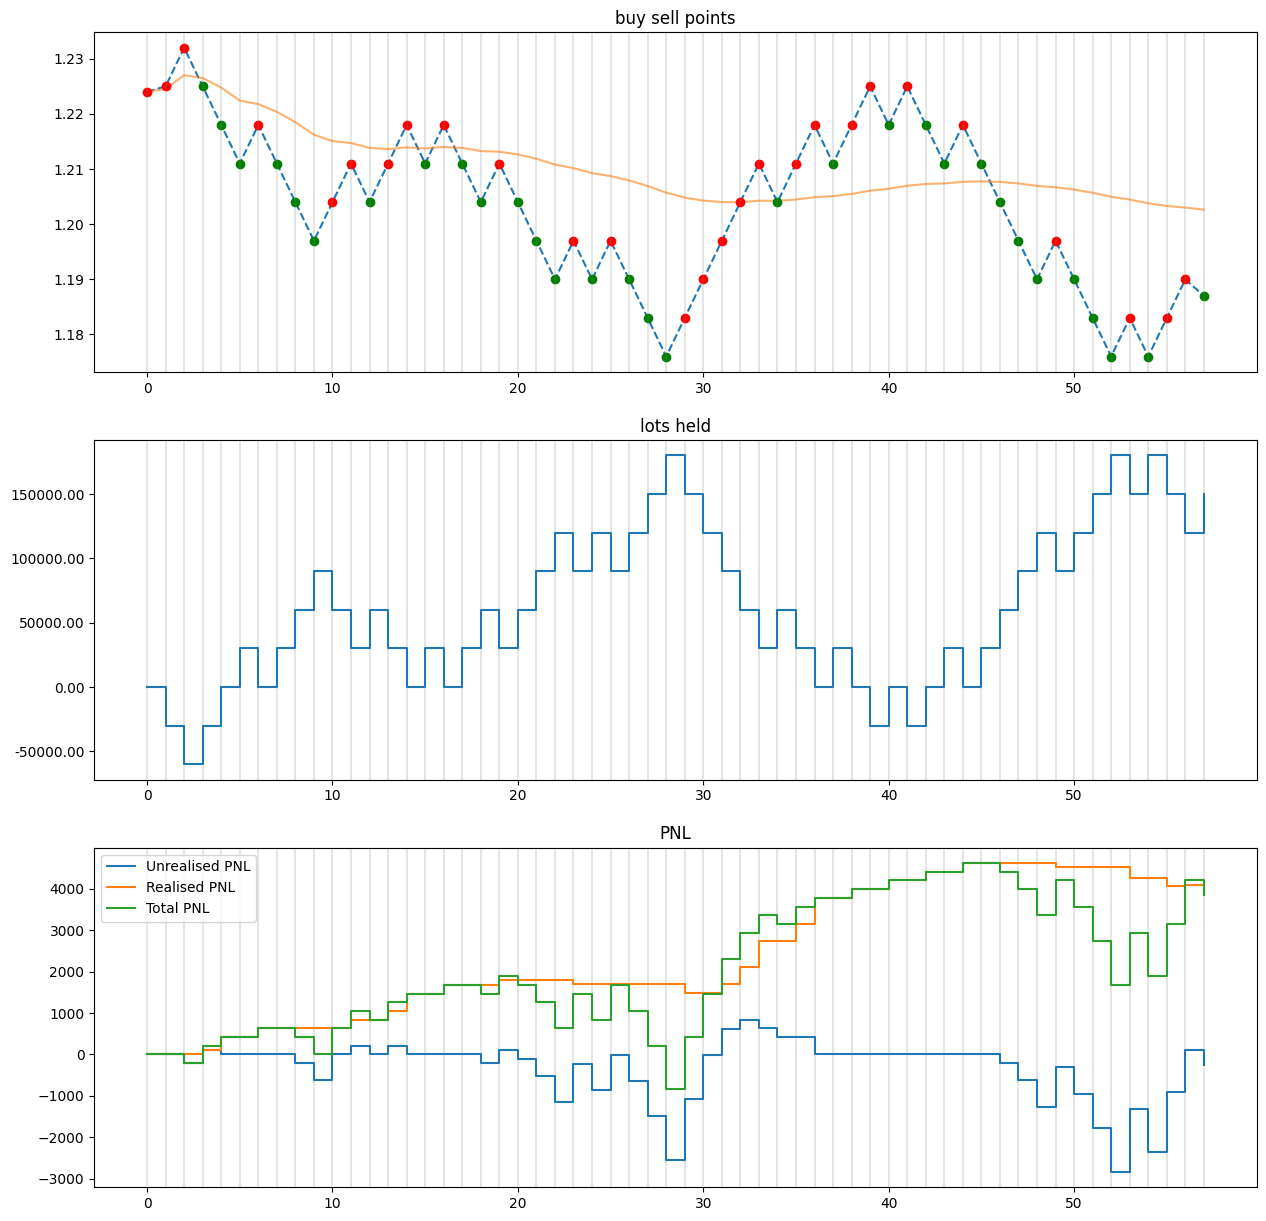

In [12]:
print(run_strategy_optimised(tick_data,optimal_G,optimal_n))
_ = run_strategy_eval(tick_data,optimal_G,optimal_n,trade_plot=True)

## Grid based search

In [13]:
ladder_sizing_grid = np.round(np.arange(0.001,0.01,0.0005),5)
print(ladder_sizing_grid)
lot_sizing_grid = np.arange(100000,2000000,100000)
print(lot_sizing_grid)

[0.001  0.0015 0.002  0.0025 0.003  0.0035 0.004  0.0045 0.005  0.0055
 0.006  0.0065 0.007  0.0075 0.008  0.0085 0.009  0.0095]
[ 100000  200000  300000  400000  500000  600000  700000  800000  900000
 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000
 1900000]


In [14]:
# heat map of profits for different ladder sizing and position sizing

def profit_map(tick_data, ladder_sizing, position_sizing):
    n_ladders = len(ladder_sizing)
    n_positions = len(position_sizing)
    profits = np.zeros((n_ladders, n_positions))
    # Initialize tqdm progress bar
    pbar = tqdm(total=n_ladders * n_positions)
    max_profit = -np.inf
    optimal_G = 0
    optimal_n = 0
    for i in range(n_ladders):
        for j in range(n_positions):
            max_loss,R_PNL,_,_ = run_strategy_optimised(tick_data, ladder_sizing[i], position_sizing[j])
            if (max_loss > -500000):
                # Update the progress bar
                pbar.update(1)
                profits[i, j] = R_PNL
                if R_PNL > max_profit:
                    max_profit = R_PNL
                    optimal_G = ladder_sizing[i]
                    optimal_n = position_sizing[j]
            else:
                # Update the progress bar
                pbar.update(1)
                profits[i, j] = np.nan
    # Close the progress bar
    pbar.close()
    
    return profits,optimal_G,optimal_n,max_profit


def profit_heat_map(profits, ladder_sizing, position_sizing):
    plt.figure(figsize=(20,15))
    
    # Create the heatmap without annotations
    ax = sns.heatmap(profits, cbar=True,alpha=0.7)
    
    # Manually add annotations shifted by the desired amount
    for i in range(len(ladder_sizing)):
        for j in range(len(position_sizing)):
            ax.text(j+0.5, i+0.5, f"{profits[i, j]:.2f}", 
                    ha='center', va='center', color='black', fontsize=10)
    
    plt.xticks(np.arange(len(position_sizing)) + 0.5, position_sizing)
    plt.yticks(np.arange(len(ladder_sizing)) + 0.5, ladder_sizing)
    plt.xlabel('Position Sizing')
    plt.ylabel('Ladder Sizing')
    plt.title('Realised Profit Heat Map')
    plt.show()


In [15]:
time1 = time.time()
profits,optimal_g,optimal_n,max_profit = profit_map(tick_data,ladder_sizing_grid,lot_sizing_grid)
time2 = time.time()
print('time taken is: ',time2-time1)

100%|██████████| 342/342 [00:12<00:00, 26.99it/s]

time taken is:  12.751276016235352


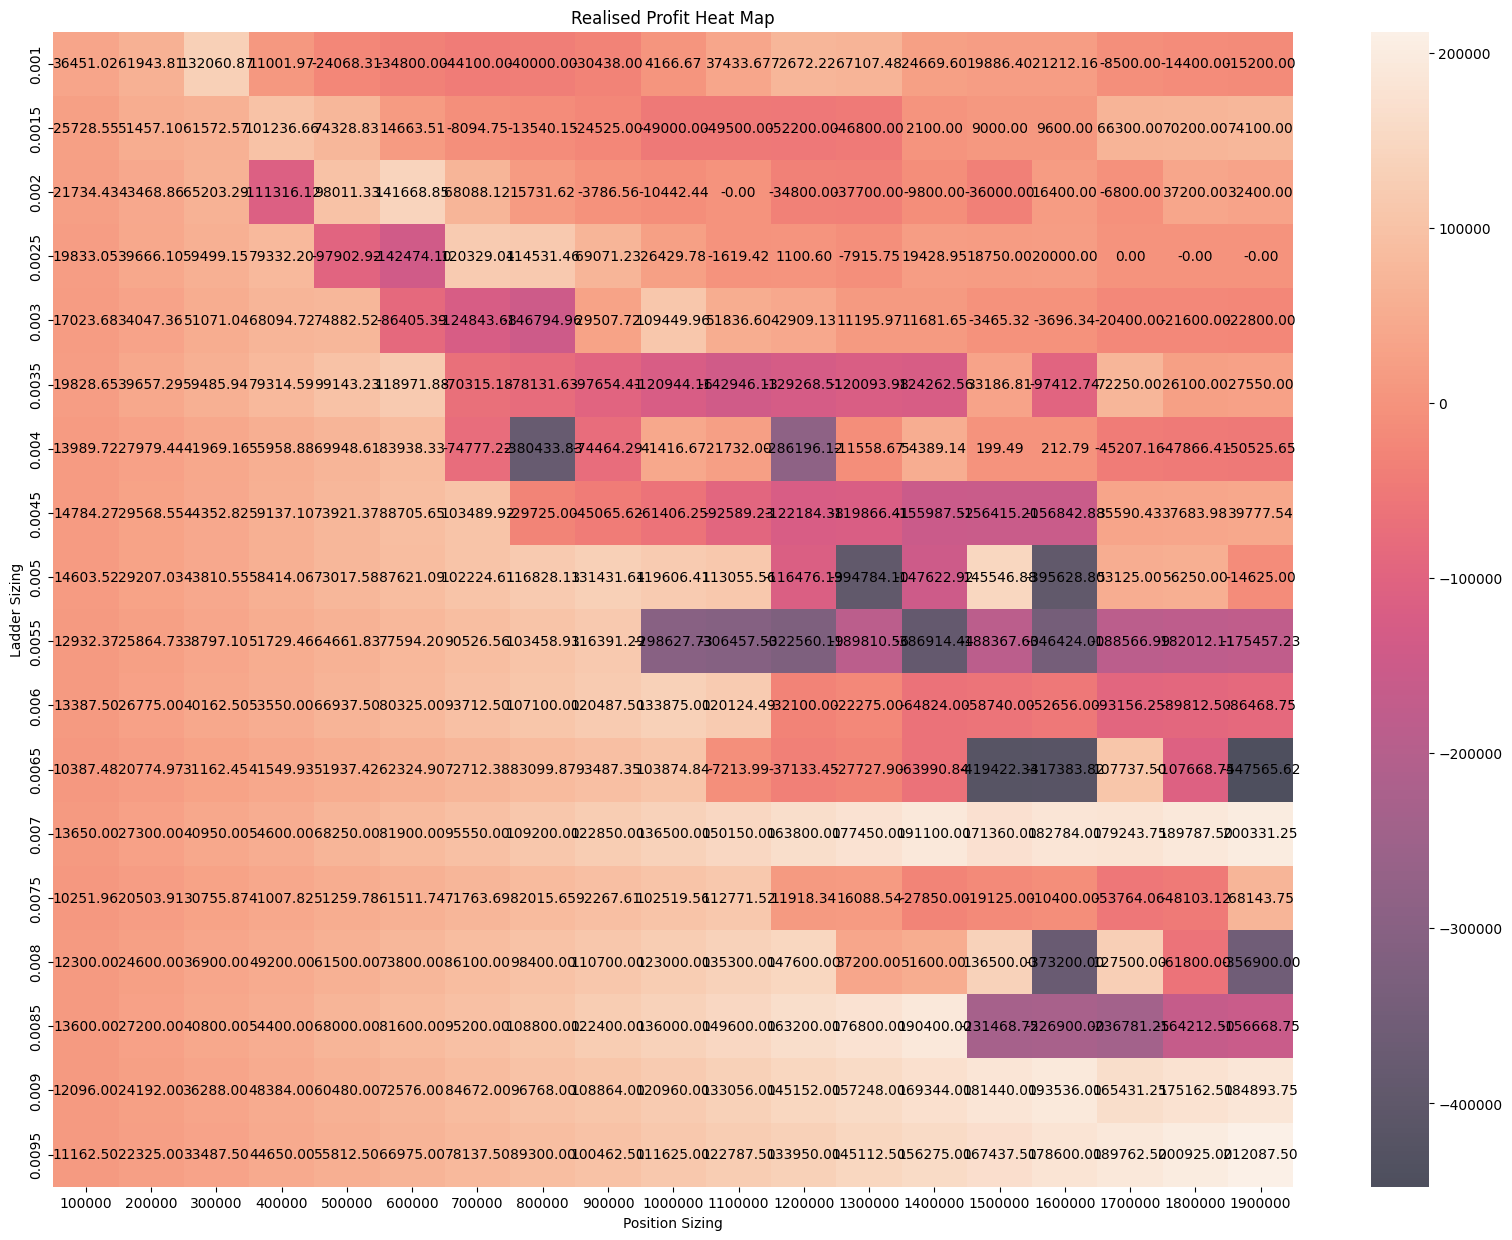

In [17]:
profit_heat_map(profits,ladder_sizing_grid,lot_sizing_grid)

In [21]:
def profit_map(tick_data, ladder_sizing, position_sizing):
    n_ladders = len(ladder_sizing)
    n_positions = len(position_sizing)
    profits = np.zeros((n_ladders, n_positions))
    # Initialize tqdm progress bar
    pbar = tqdm(total=n_ladders * n_positions)
    max_sharpe = -np.inf
    optimal_G = 0
    optimal_n = 0
    for i in range(n_ladders):
        for j in range(n_positions):
            max_loss,R_PNL,_,std = run_strategy_optimised(tick_data, ladder_sizing[i], position_sizing[j])
            if (max_loss > -500000):
                # Update the progress bar
                pbar.update(1)
                profits[i, j] = R_PNL/std
                if R_PNL/std > max_sharpe:
                    max_profit = R_PNL/std
                    optimal_G = ladder_sizing[i]
                    optimal_n = position_sizing[j]
            else:
                # Update the progress bar
                pbar.update(1)
                profits[i, j] = np.nan
    # Close the progress bar
    pbar.close()
    
    return profits,optimal_G,optimal_n,max_profit

In [22]:
time1 = time.time()
profits,optimal_g,optimal_n,max_profit = profit_map(tick_data,ladder_sizing_grid,lot_sizing_grid)
time2 = time.time()
print('time taken is: ',time2-time1)

  0%|          | 0/342 [00:00<?, ?it/s]

100%|██████████| 342/342 [00:12<00:00, 26.69it/s]

time taken is:  12.816697120666504


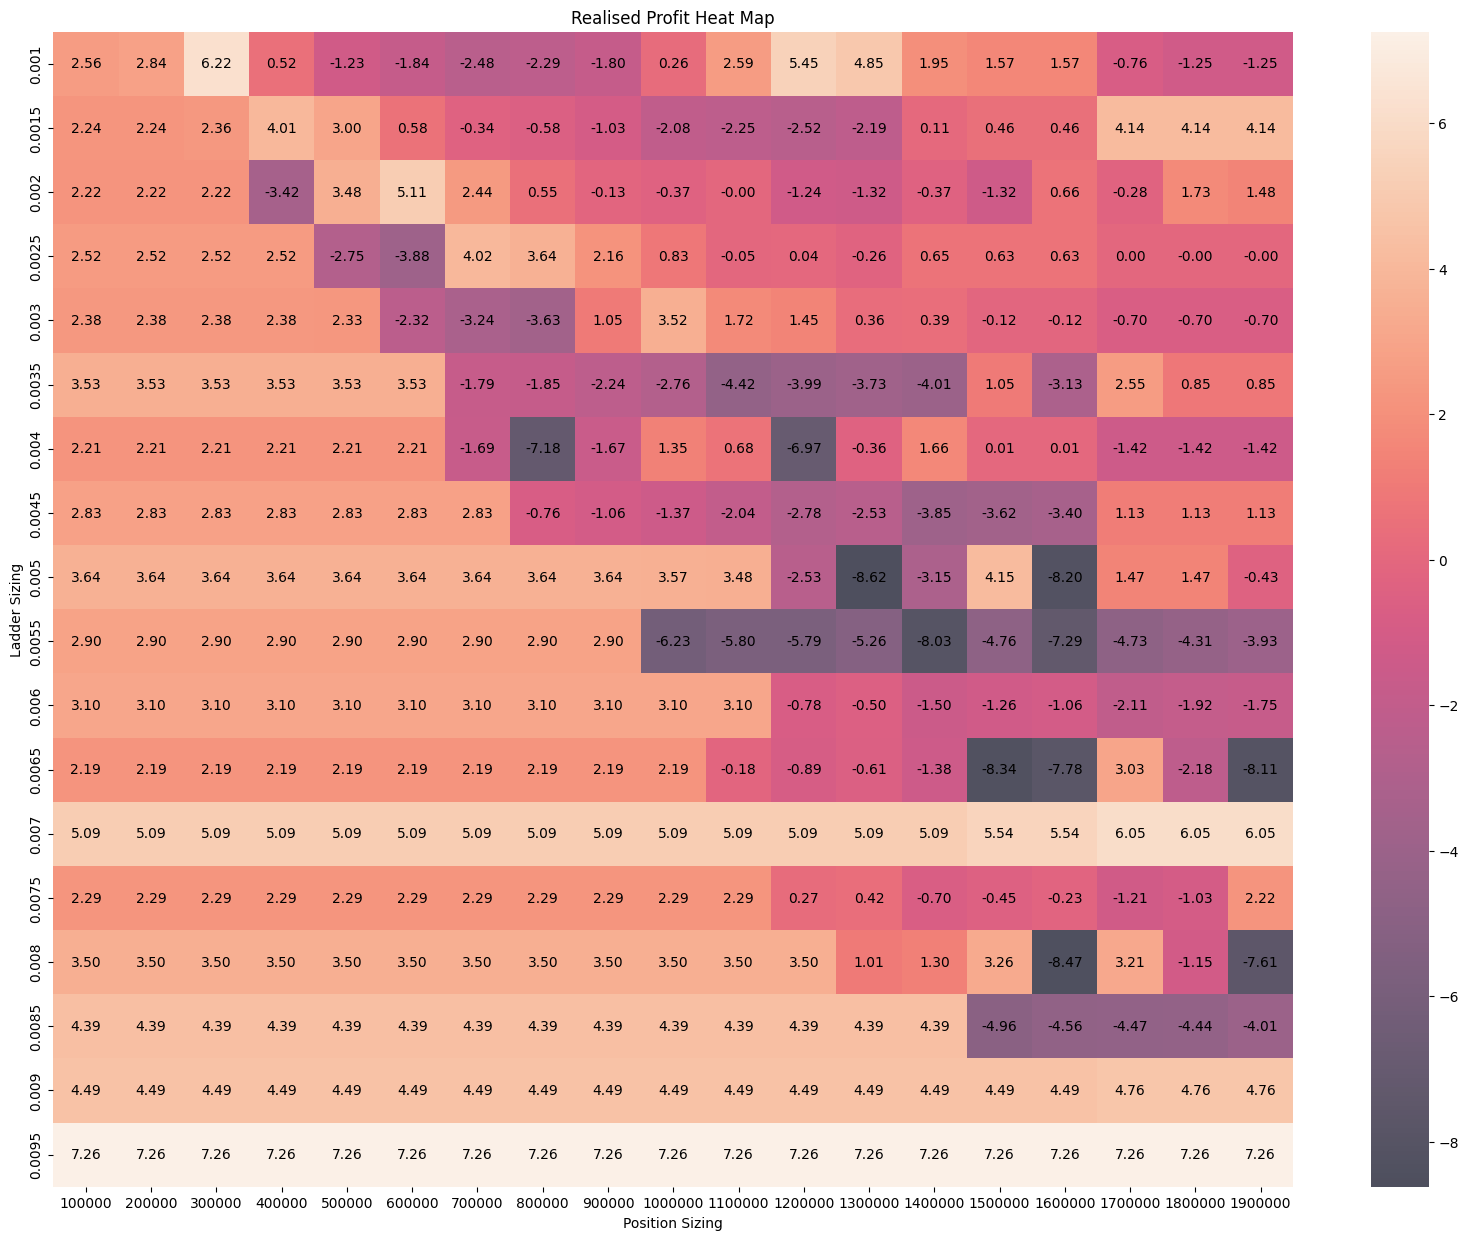

In [23]:
profit_heat_map(profits,ladder_sizing_grid,lot_sizing_grid)

In [24]:
optimal_g,optimal_n,max_profit

(0.0095, 1900000, 7.257001796213315)

Ladderization time: 0.029975175857543945
Indicator preparation time: 0.0006337165832519531
Position sizing time: 0.00011110305786132812
PNL calculation time: 0.01001596450805664


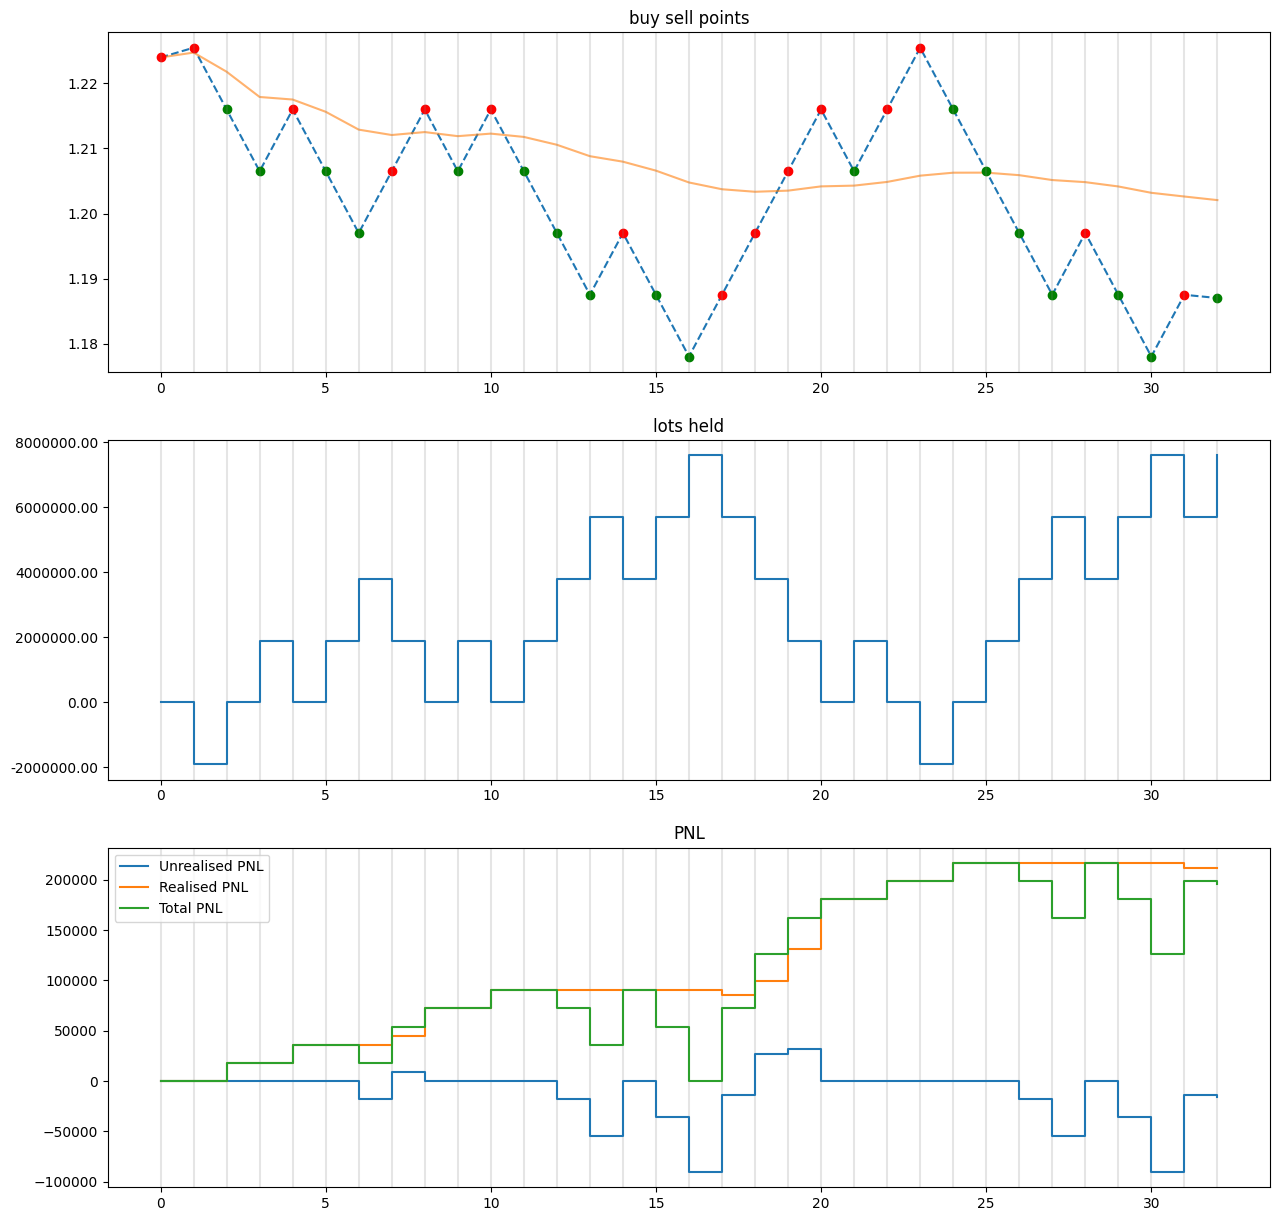

In [26]:
_=run_strategy_eval(tick_data, optimal_g,optimal_n,trade_plot=True)

## Walk forward Analysis

In [27]:
def error_check(params,n):
    if len(params) != n:
        raise IndexError('The number of parameters is not correct')

### grid_search function

In [32]:
def Grid_Search(train_data,test_data,parameters,optimization_params):
    
    error_check(parameters,2)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    
    ladder_sizing_grid = np.arange(grid_params[0],grid_params[1],grid_params[2])
    lot_sizing_grid = np.arange(position_params[0],position_params[1],position_params[2])
    
    max_profit = -np.inf
    optimal_g = 0
    optimal_n = 0
    for ladder_size in ladder_sizing_grid:
        for lot_size in lot_sizing_grid:
            max_loss, R_PNL, profit,_ = run_strategy_optimised(train_data, ladder_size, lot_size)
            if (max_loss > -500000):
                if profit > max_profit:
                    max_profit = profit
                    optimal_g = ladder_size
                    optimal_n = lot_size
            else:
                break
    max_loss,R_PNL,profit,_ = run_strategy_optimised(test_data, optimal_g,optimal_n)
    return max_loss, R_PNL,profit,[optimal_g,optimal_n]

In [33]:
Grid_Search(tick_data,tick_data,[[0.001,0.01,0.0005],[100000,2000000,100000]],None)

(-39900.0, 200331.2501, 214700.0, [0.007, 1900000])

In [38]:
def Grid_Search_std(train_data,test_data,parameters,optimization_params):
    
    error_check(parameters,2)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    
    ladder_sizing_grid = np.arange(grid_params[0],grid_params[1],grid_params[2])
    lot_sizing_grid = np.arange(position_params[0],position_params[1],position_params[2])
    
    max_sharpe = -np.inf
    optimal_g = 0
    optimal_n = 0
    for ladder_size in ladder_sizing_grid:
        for lot_size in lot_sizing_grid:
            max_loss, R_PNL, profit,std = run_strategy_optimised(train_data, ladder_size, lot_size)
            if (max_loss > -500000):
                if profit/std > max_sharpe:
                    max_sharpe = profit/std
                    optimal_g = ladder_size
                    optimal_n = lot_size
            else:
                break
    max_loss,R_PNL,profit,_ = run_strategy_optimised(test_data, optimal_g,optimal_n)
    return max_loss, R_PNL,profit,[optimal_g,optimal_n]

In [40]:
Grid_Search_std(tick_data,tick_data,[[0.001,0.01,0.0005],[100000,2000000,100000]],None)

(-150000.0, 132060.8727, 144300.0, [0.001, 300000])

In [22]:
def Grid_Search_multiplier(train_data,test_data,parameters,optimization_params):
    
    error_check(parameters,4)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    multiplier_params = parameters[2]
    lookback_params = parameters[3]
    
    ladder_sizing_grid = np.arange(grid_params[0],grid_params[1],grid_params[2])
    lot_sizing_grid = np.arange(position_params[0],position_params[1],position_params[2])
    multiplier_grid = np.arange(multiplier_params[0],multiplier_params[1],multiplier_params[2])

    max_profit = -np.inf
    optimal_g = 0
    optimal_n = 0
    for ladder_size in ladder_sizing_grid:
        for lot_size in lot_sizing_grid:
            for multiplier in multiplier_grid:
                for lookback in lookback_params:
                    max_loss, R_PNL, profit = run_strategy_optimised(tick_data, ladder_size, lot_size, multiplier=multiplier, lookback=lookback)
                    if (max_loss > -500000):
                        if profit > max_profit:
                            max_profit = profit
                            optimal_g = ladder_size
                            optimal_n = lot_size
                            optimal_multiplier = multiplier
                            optimal_lookback = lookback
                    else:
                        break
    max_loss,R_PNL,profit = run_strategy_optimised(test_data, optimal_g,optimal_n,optimal_multiplier,optimal_lookback)
    return max_loss, R_PNL,profit,[optimal_g,optimal_n,optimal_multiplier,optimal_lookback]

In [ ]:
Grid_Search_multiplier(tick_data,tick_data,[[0.001,0.01,0.0005],[100000,2000000,100000],[1,3,0.2],[9,20,50,100,150,200]],None)

### brute force search similar to above

In [25]:
def brute_force_search(train_data,test_data,parameters,optimization_params):

    def objective_function(params, tick_data, test_data):
        if len(params) == 2:
            ladder_size, lot_size = params
            max_loss, R_PNL, profit = run_strategy_optimised(train_data, ladder_size, lot_size)
        elif len(params) == 4:
            ladder_size,lot_size,multiplier,lookback = params
            max_loss, R_PNL, profit = run_strategy_optimised(train_data, ladder_size, lot_size,multiplier=multiplier,lookback = lookback)
        elif len(params) == 5:
            ladder_size,lot_size,indicator,lookback,scaling_factor = params
            max_loss, R_PNL, profit = run_strategy_optimised(train_data, ladder_size, lot_size,indicator_type = indicator, lookback = lookback, indicator_scale = scaling_factor)
        else:
            RaiseError('The number of parameters is not correct')
        
        if max_loss > -500000:
            return -profit  # Minimize negative profit to maximize profit
        else:
            return np.inf  # Penalize configurations leading to unacceptable loss

    # Define parameter ranges
    grid_ranges = [slice(*parameter) for parameter in parameters]
    # Run optimization
    optimal_params = brute(objective_function, grid_ranges, args=(train_data, test_data), full_output=True, finish=fmin)

    for i in range(len(optimal_params[0])):
        optimal_params[0][i] = round(optimal_params[0][i]/parameters[i][2])*parameters[i][2]
    print(optimal_params[0])
    if len(optimal_params[0]) == 2:
        ladder_size, lot_size = optimal_params[0]
        max_loss, R_PNL, profit = run_strategy_optimised(test_data, ladder_size, lot_size)
    elif len(optimal_params[0]) == 4:
        ladder_size,lot_size,multiplier,lookback = optimal_params[0]
        max_loss, R_PNL, profit = run_strategy_optimised(test_data, ladder_size, lot_size,multiplier=multiplier,lookback = lookback)
    elif len(params) == 5:
        ladder_size,lot_size,indicator,lookback,scaling_factor = optimal_params[0]
        max_loss, R_PNL, profit = run_strategy_optimised(test_data, ladder_size, lot_size,indicator_type = indicator, lookback = lookback, indicator_scale = scaling_factor)

    return max_loss, R_PNL, profit, optimal_params[0]


In [26]:
brute_force_search(tick_data,tick_data,[[0.001,0.01,0.0005],[100000,2000000,100000]],None)

[7.0e-03 1.9e+06]


(-39900.0, 200331.2501, 214700.0, array([7.0e-03, 1.9e+06]))

### Optuna functions

In [41]:
def optuna_optimiser(train_data,test_data,parameters,optimization_params):
    n_trials = optimization_params[0]

    error_check(parameters,2)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    
    def objective_optuna(trial, tick_data):
        G = trial.suggest_int("G", grid_params[0]/grid_params[2], grid_params[1]/grid_params[2])*grid_params[2]
        n = trial.suggest_int("n", position_params[0]/position_params[2], position_params[1]/position_params[2])*position_params[2]
        
        max_loss,R_PNL,profit,_ = run_strategy_optimised(tick_data,G,n)
        
        # Constraints
        if max_loss < -500e3:
            return float('inf')
        return -profit # We negate the value since we want to maximize Profit

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective_optuna(trial, train_data), n_trials=n_trials)
    
    optimal_g = np.round(study.best_params["G"]*grid_params[2],5)
    optimal_n = study.best_params["n"]*position_params[2]
    
    print("optimisation completed")
    max_loss,R_PNL,profit,_ = run_strategy_optimised(test_data, optimal_g,optimal_n)
    return max_loss, R_PNL,profit,[optimal_g,optimal_n]

In [42]:
def optuna_optimiser_std(train_data,test_data,parameters,optimization_params):
    n_trials = optimization_params[0]

    error_check(parameters,2)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    
    def objective_optuna(trial, tick_data):
        G = trial.suggest_int("G", grid_params[0]/grid_params[2], grid_params[1]/grid_params[2])*grid_params[2]
        n = trial.suggest_int("n", position_params[0]/position_params[2], position_params[1]/position_params[2])*position_params[2]
        
        max_loss,R_PNL,profit,std = run_strategy_optimised(tick_data,G,n)
        
        # Constraints
        if max_loss < -500e3:
            return float('inf')
        return -profit/std # We negate the value since we want to maximize Profit

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective_optuna(trial, train_data), n_trials=n_trials)
    
    optimal_g = np.round(study.best_params["G"]*grid_params[2],5)
    optimal_n = study.best_params["n"]*position_params[2]
    
    print("optimisation completed")
    max_loss,R_PNL,profit,_ = run_strategy_optimised(test_data, optimal_g,optimal_n)
    return max_loss, R_PNL,profit,[optimal_g,optimal_n]

In [43]:
def optuna_optimiser_multiplier(train_data,test_data,parameters,optimization_params):
    n_trials = optimization_params[0]

    error_check(parameters,4)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    multiplier_params = parameters[2]
    lookback_params = parameters[3]
    
    def objective_optuna(trial, tick_data):
        G = trial.suggest_int("G", grid_params[0]/grid_params[2], grid_params[1]/grid_params[2])*grid_params[2]
        n = trial.suggest_int("n", position_params[0]/position_params[2], position_params[1]/position_params[2])*position_params[2]
        multiplier = trial.suggest_int("multiplier", multiplier_params[0]/multiplier_params[2], multiplier_params[1]/multiplier_params[2])*multiplier_params[2]
        lookback = trial.suggest_categorical("lookback", lookback_params)
        
        max_loss,R_PNL,profit,std = run_strategy_optimised(tick_data, G, n, multiplier = multiplier,lookback = lookback)
        
        # Constraints
        if max_loss < -500e3:
            return float('inf')
        return -profit # We negate the value since we want to maximize Profit

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective_optuna(trial, train_data), n_trials=n_trials)
    
    optimal_g = np.round(study.best_params["G"]*grid_params[2],5)
    optimal_n = study.best_params["n"]*position_params[2]
    optimal_m = study.best_params["multiplier"]*multiplier_params[2]
    optimal_l = study.best_params["lookback"]
    
    print("optimisation completed")
    max_loss, R_PNL,profit,std = run_strategy_optimised(test_data, optimal_g,optimal_n,multiplier = optimal_m,lookback = optimal_l)
    return max_loss, R_PNL,profit,[optimal_g,optimal_n,optimal_m,optimal_l]

In [44]:
def optuna_optimiser_multiplier_std(train_data,test_data,parameters,optimization_params):
    n_trials = optimization_params[0]

    error_check(parameters,4)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    multiplier_params = parameters[2]
    lookback_params = parameters[3]
    
    def objective_optuna(trial, tick_data):
        G = trial.suggest_int("G", grid_params[0]/grid_params[2], grid_params[1]/grid_params[2])*grid_params[2]
        n = trial.suggest_int("n", position_params[0]/position_params[2], position_params[1]/position_params[2])*position_params[2]
        multiplier = trial.suggest_int("multiplier", multiplier_params[0]/multiplier_params[2], multiplier_params[1]/multiplier_params[2])*multiplier_params[2]
        lookback = trial.suggest_categorical("lookback", lookback_params)
        
        max_loss,R_PNL,profit,std = run_strategy_optimised(tick_data, G, n, multiplier = multiplier,lookback = lookback)
        
        # Constraints
        if max_loss < -500e3:
            return float('inf')
        return -profit/std # We negate the value since we want to maximize Profit

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective_optuna(trial, train_data), n_trials=n_trials)
    
    optimal_g = np.round(study.best_params["G"]*grid_params[2],5)
    optimal_n = study.best_params["n"]*position_params[2]
    optimal_m = study.best_params["multiplier"]*multiplier_params[2]
    optimal_l = study.best_params["lookback"]
    
    print("optimisation completed")
    max_loss, R_PNL,profit,std = run_strategy_optimised(test_data, optimal_g,optimal_n,multiplier = optimal_m,lookback = optimal_l)
    return max_loss, R_PNL,profit,[optimal_g,optimal_n,optimal_m,optimal_l]

In [45]:
def optuna_optimiser_indicator(train_data,test_data,parameters,optimization_params):
    n_trials = optimization_params[0]

    error_check(parameters,5)

    grid_params = parameters[0]
    position_params = parameters[1]
    indicator_type_params = parameters[2]
    lookback_params = parameters[3]
    scaling_factor_params = parameters[4]

    
    def objective_optuna(trial, tick_data):
        G = trial.suggest_int("G", grid_params[0]/grid_params[2], grid_params[1]/grid_params[2])*grid_params[2]
        n = trial.suggest_int("n", position_params[0]/position_params[2], position_params[1]/position_params[2])*position_params[2]
        indicator_type = trial.suggest_categorical("indicator_type", indicator_type_params)
        lookback = trial.suggest_categorical("lookback", lookback_params)
        scaling_factor = trial.suggest_int("scaling_factor", scaling_factor_params[0]/scaling_factor_params[2], scaling_factor_params[1]/scaling_factor_params[2])*scaling_factor_params[2]
        
        max_loss,R_PNL,profit,std = run_strategy_optimised(tick_data, G, n, indicator_type = indicator_type, lookback = lookback, indicator_scale = scaling_factor)
        
        # Constraints
        if max_loss < -500e3:
            return float('inf')
        return -profit # We negate the value since we want to maximize Profit

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective_optuna(trial, train_data), n_trials=n_trials)
    
    optimal_g = np.round(study.best_params["G"]*grid_params[2],5)
    optimal_n = study.best_params["n"]*position_params[2]
    optimal_i = study.best_params["indicator_type"]
    optimal_l = study.best_params["lookback"]
    optimal_s = study.best_params["scaling_factor"]*scaling_factor_params[2]
    
    print("optimisation completed")
    max_loss, R_PNL,profit,std = run_strategy_optimised(test_data, optimal_g,optimal_n, indicator_type = optimal_i, lookback = optimal_l,indicator_scale = optimal_s)
    return max_loss,R_PNL,profit,[optimal_g,optimal_n,optimal_i,optimal_l,optimal_s]

In [47]:
def optuna_optimiser_indicator_std(train_data,test_data,parameters,optimization_params):
    n_trials = optimization_params[0]

    error_check(parameters,5)

    grid_params = parameters[0]
    position_params = parameters[1]
    indicator_type_params = parameters[2]
    lookback_params = parameters[3]
    scaling_factor_params = parameters[4]

    
    def objective_optuna(trial, tick_data):
        G = trial.suggest_int("G", grid_params[0]/grid_params[2], grid_params[1]/grid_params[2])*grid_params[2]
        n = trial.suggest_int("n", position_params[0]/position_params[2], position_params[1]/position_params[2])*position_params[2]
        indicator_type = trial.suggest_categorical("indicator_type", indicator_type_params)
        lookback = trial.suggest_categorical("lookback", lookback_params)
        scaling_factor = trial.suggest_int("scaling_factor", scaling_factor_params[0]/scaling_factor_params[2], scaling_factor_params[1]/scaling_factor_params[2])*scaling_factor_params[2]
        
        max_loss,R_PNL,profit,std = run_strategy_optimised(tick_data, G, n, indicator_type = indicator_type, lookback = lookback, indicator_scale = scaling_factor)
        
        # Constraints
        if max_loss < -500e3:
            return float('inf')
        return -profit/std # We negate the value since we want to maximize Profit

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective_optuna(trial, train_data), n_trials=n_trials)
    
    optimal_g = np.round(study.best_params["G"]*grid_params[2],5)
    optimal_n = study.best_params["n"]*position_params[2]
    optimal_i = study.best_params["indicator_type"]
    optimal_l = study.best_params["lookback"]
    optimal_s = study.best_params["scaling_factor"]*scaling_factor_params[2]
    
    print("optimisation completed")
    max_loss, R_PNL,profit,std = run_strategy_optimised(test_data, optimal_g,optimal_n, indicator_type = optimal_i, lookback = optimal_l,indicator_scale = optimal_s)
    return max_loss,R_PNL,profit,[optimal_g,optimal_n,optimal_i,optimal_l,optimal_s]

### walk forward

In [48]:
def generate_date_ranges_for_walk_forward(start_month_year, end_month_year, day=15, n_months = 1):
    # Initialize an empty list to store the date ranges
    date_ranges = []
    if day not in range(1, 29):
        raise ValueError('Day must be between 1 and 28')
    # Convert the input strings to datetime objects, using the given day
    start_date = datetime.strptime(f"{day} {start_month_year}", '%d %b %Y')
    end_date = datetime.strptime(f"{day} {end_month_year}", '%d %b %Y')
    
    # Generate the date ranges
    current_date = start_date
    while current_date <= end_date:
        next_date = current_date + relativedelta(months=n_months)
        date_range = [current_date.strftime('%d %b %Y'), (next_date - relativedelta(days=1)).strftime('%d %b %Y')]
        date_ranges.append(date_range)
        current_date = next_date
    
    return date_ranges[:-1]


In [49]:
def get_previous_n_months(end_date_str, n_months):
    # Convert the input string to a datetime object
    end_date = datetime.strptime(end_date_str, '%d %b %Y')
    
    # Calculate the start date
    start_date = end_date - relativedelta(months=n_months)
    
    # Create the date range
    date_range = [start_date.strftime('%d %b %Y'), (end_date - relativedelta(days=1)).strftime('%d %b %Y')]
    
    return date_range


In [50]:
generate_date_ranges_for_walk_forward('jan 2021', 'jan 2022', day=15, n_months = 3)

[['15 Jan 2021', '14 Apr 2021'],
 ['15 Apr 2021', '14 Jul 2021'],
 ['15 Jul 2021', '14 Oct 2021'],
 ['15 Oct 2021', '14 Jan 2022']]

In [51]:
def walk_forward_analysis(evaluation_start, evaluation_end, evaluation_day,parameters,optimization_function = Grid_Search, optimizer_params =[],  lookback_in_months = 6,evaluation_period = 3):
    generated_date_ranges = generate_date_ranges_for_walk_forward(evaluation_start, evaluation_end,evaluation_day,n_months = evaluation_period)
    df = {}
    for dates in generated_date_ranges:
        train_period = get_previous_n_months(dates[0], lookback_in_months)
        train_data = data_gather_from_files(train_period[0],train_period[1])['EURUSD.mid']
        print('Data gathered for training period: ',train_period[0],train_period[1])
        test_data = data_gather_from_files(dates[0],dates[1])['EURUSD.mid']
        print('Data gathered for testing period: ',dates[0],dates[1])
        max_loss,R_PNL,profit,optimal_params = optimization_function(train_data,test_data,parameters,optimizer_params)
        print('Optimal parameters are: ',optimal_params)
        print('Max loss,R_PNL,profit are: ',max_loss, R_PNL,profit)
        df[dates[0] +'-'+ dates[1]] = [max_loss, R_PNL,profit]
    df = pd.DataFrame(df).T
    df.columns = ['max_loss', 'R_PNL','profit']
    return df

### tests

In [52]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]

n_grid_params = int((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = int((lot_params[1]-lot_params[0])/lot_params[2])

print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params))

parameters = [grid_params,lot_params]
optimizer_param = []
results = walk_forward_analysis('jan 2021','jan 2022',1,parameters,optimization_function=Grid_Search,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)
results

number of grid params:- 18
number of lot params:- 19
total_number_of_combinations:- 342
Data gathered for training period:  01 Jul 2020 31 Dec 2020
Data gathered for testing period:  01 Jan 2021 31 Mar 2021
Optimal parameters are:  [0.0025, 1600000]
Max loss,R_PNL,profit are:  -21600.0 91199.9997 -21600.0
Data gathered for training period:  01 Oct 2020 31 Mar 2021
Data gathered for testing period:  01 Apr 2021 30 Jun 2021
Optimal parameters are:  [0.009500000000000001, 1600000]
Max loss,R_PNL,profit are:  -121600.0 77320.0 98400.0
Data gathered for training period:  01 Jan 2021 30 Jun 2021
Data gathered for testing period:  01 Jul 2021 30 Sep 2021
Optimal parameters are:  [0.009500000000000001, 1900000]
Max loss,R_PNL,profit are:  0 65455.0 58710.0
Data gathered for training period:  01 Apr 2021 30 Sep 2021
Data gathered for testing period:  01 Oct 2021 31 Dec 2021
Optimal parameters are:  [0.009000000000000001, 1600000]
Max loss,R_PNL,profit are:  -28800.0 48888.8889 66240.0


,max_loss,R_PNL,profit
01 Jan 2021-31 Mar 2021,-21600.00000,91199.99970,-21600.00000
01 Apr 2021-30 Jun 2021,-121600.00000,77320.00000,98400.00000
01 Jul 2021-30 Sep 2021,0.00000,65455.00000,58710.00000
01 Oct 2021-31 Dec 2021,-28800.00000,48888.88890,66240.00000


In [53]:
results = walk_forward_analysis('jan 2021','jan 2022',1,parameters,optimization_function=Grid_Search_std,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)
results

Data gathered for training period:  01 Jul 2020 31 Dec 2020
Data gathered for testing period:  01 Jan 2021 31 Mar 2021
Optimal parameters are:  [0.0025, 1600000]
Max loss,R_PNL,profit are:  -21600.0 91199.9997 -21600.0
Data gathered for training period:  01 Oct 2020 31 Mar 2021
Data gathered for testing period:  01 Apr 2021 30 Jun 2021
Optimal parameters are:  [0.001, 100000]
Max loss,R_PNL,profit are:  -115900.0 28044.1574 32900.0
Data gathered for training period:  01 Jan 2021 30 Jun 2021
Data gathered for testing period:  01 Jul 2021 30 Sep 2021
Optimal parameters are:  [0.009500000000000001, 700000]
Max loss,R_PNL,profit are:  0 24115.0 21630.0
Data gathered for training period:  01 Apr 2021 30 Sep 2021
Data gathered for testing period:  01 Oct 2021 31 Dec 2021
Optimal parameters are:  [0.001, 100000]
Max loss,R_PNL,profit are:  -49100.0 15402.7823 18020.0


,max_loss,R_PNL,profit
01 Jan 2021-31 Mar 2021,-21600.00000,91199.99970,-21600.00000
01 Apr 2021-30 Jun 2021,-115900.00000,28044.15740,32900.00000
01 Jul 2021-30 Sep 2021,0.00000,24115.00000,21630.00000
01 Oct 2021-31 Dec 2021,-49100.00000,15402.78230,18020.00000


In [54]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]

n_grid_params = ((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = ((lot_params[1]-lot_params[0])/lot_params[2])

print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params))

n_trials = 300
optimizer_param = [n_trials]

print('search_space_explored:-',(n_trials/(n_grid_params*n_lot_params))*100,'%')

parameters = [grid_params,lot_params]

results = walk_forward_analysis('jan 2021','jan 2022',1,parameters,optimization_function=optuna_optimiser,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)
results

number of grid params:- 18.0
number of lot params:- 19.0
total_number_of_combinations:- 342.0
search_space_explored:- 87.71929824561403 %
Data gathered for training period:  01 Jul 2020 31 Dec 2020
Data gathered for testing period:  01 Jan 2021 31 Mar 2021
optimisation completed
Optimal parameters are:  [0.0025, 1600000]
Max loss,R_PNL,profit are:  -21600.0 91199.9997 -21600.0
Data gathered for training period:  01 Oct 2020 31 Mar 2021
Data gathered for testing period:  01 Apr 2021 30 Jun 2021
optimisation completed
Optimal parameters are:  [0.0095, 1600000]
Max loss,R_PNL,profit are:  -121600.0 77320.0 98400.0
Data gathered for training period:  01 Jan 2021 30 Jun 2021
Data gathered for testing period:  01 Jul 2021 30 Sep 2021
optimisation completed
Optimal parameters are:  [0.0095, 2000000]
Max loss,R_PNL,profit are:  0 68900.0 61800.0
Data gathered for training period:  01 Apr 2021 30 Sep 2021
Data gathered for testing period:  01 Oct 2021 31 Dec 2021
optimisation completed
Optimal 

,max_loss,R_PNL,profit
01 Jan 2021-31 Mar 2021,-21600.00000,91199.99970,-21600.00000
01 Apr 2021-30 Jun 2021,-121600.00000,77320.00000,98400.00000
01 Jul 2021-30 Sep 2021,0.00000,68900.00000,61800.00000
01 Oct 2021-31 Dec 2021,-28800.00000,48888.88890,66240.00000


In [55]:
results = walk_forward_analysis('jan 2021','jan 2022',1,parameters,optimization_function=optuna_optimiser_std,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)

Data gathered for training period:  01 Jul 2020 31 Dec 2020
Data gathered for testing period:  01 Jan 2021 31 Mar 2021
optimisation completed
Optimal parameters are:  [0.0025, 2000000]
Max loss,R_PNL,profit are:  -41600.0 62500.0001 -41600.0
Data gathered for training period:  01 Oct 2020 31 Mar 2021
Data gathered for testing period:  01 Apr 2021 30 Jun 2021
optimisation completed
Optimal parameters are:  [0.009, 300000]
Max loss,R_PNL,profit are:  -21600.0 16686.0 21000.0
Data gathered for training period:  01 Jan 2021 30 Jun 2021
Data gathered for testing period:  01 Jul 2021 30 Sep 2021
optimisation completed
Optimal parameters are:  [0.0095, 1700000]
Max loss,R_PNL,profit are:  0 58565.0 52530.0
Data gathered for training period:  01 Apr 2021 30 Sep 2021
Data gathered for testing period:  01 Oct 2021 31 Dec 2021
optimisation completed
Optimal parameters are:  [0.001, 100000]
Max loss,R_PNL,profit are:  -49100.0 15402.7823 18020.0


#### multiplier parameter case 

In [56]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]
multiplier_params = [1,3,0.1]
lookback_params = [9,20,30,50,100,150,200]

n_grid_params = ((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = ((lot_params[1]-lot_params[0])/lot_params[2])
n_multiplier_params = ((multiplier_params[1]-multiplier_params[0])/multiplier_params[2])
n_lookback_params = len(lookback_params)
print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('number of multiplier params:-',(n_multiplier_params))
print('number of lookback params:-',(n_lookback_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params*n_multiplier_params*n_lookback_params))

n_trials = 1000
optimizer_param = [n_trials]

print('search_space_explored:-',(n_trials/(n_grid_params*n_lot_params*n_multiplier_params*n_lookback_params))*100,'%')
parameters1 = [grid_params,lot_params,multiplier_params,lookback_params]
results1 = walk_forward_analysis('jan 2021','jan 2022',1,parameters1,optimization_function=optuna_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)
results1

number of grid params:- 18.0
number of lot params:- 19.0
number of multiplier params:- 20.0
number of lookback params:- 7
total_number_of_combinations:- 47880.0
search_space_explored:- 2.0885547201336676 %
Data gathered for training period:  01 Jul 2020 31 Dec 2020
Data gathered for testing period:  01 Jan 2021 31 Mar 2021
optimisation completed
Optimal parameters are:  [0.006, 1400000, 2.5, 30]
Max loss,R_PNL,profit are:  -77420.0 2645.4545 -77420.0
Data gathered for training period:  01 Oct 2020 31 Mar 2021
Data gathered for testing period:  01 Apr 2021 30 Jun 2021
optimisation completed
Optimal parameters are:  [0.004, 1700000, 2.4000000000000004, 30]
Max loss,R_PNL,profit are:  -152680.1711 -124703.0283 -117320.1711
Data gathered for training period:  01 Jan 2021 30 Jun 2021
Data gathered for testing period:  01 Jul 2021 30 Sep 2021
optimisation completed
Optimal parameters are:  [0.009, 2000000, 1.3, 200]
Max loss,R_PNL,profit are:  0 148249.8 56706.592
Data gathered for training 

,max_loss,R_PNL,profit
01 Jan 2021-31 Mar 2021,-77420.00000,2645.45450,-77420.00000
01 Apr 2021-30 Jun 2021,-152680.17110,-124703.02830,-117320.17110
01 Jul 2021-30 Sep 2021,0.00000,148249.80000,56706.59200
01 Oct 2021-31 Dec 2021,-329415.09000,-258010.12950,-258010.12800


In [57]:
results1 = walk_forward_analysis('jan 2021','jan 2022',1,parameters1,optimization_function=optuna_optimiser_multiplier_std,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)

Data gathered for training period:  01 Jul 2020 31 Dec 2020
Data gathered for testing period:  01 Jan 2021 31 Mar 2021
optimisation completed
Optimal parameters are:  [0.005, 2000000, 2.7, 20]
Max loss,R_PNL,profit are:  -14000.0 159000.0 141280.0
Data gathered for training period:  01 Oct 2020 31 Mar 2021
Data gathered for testing period:  01 Apr 2021 30 Jun 2021


In [ ]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]
I_type = ['v','a']
lookback_params = [9,20,30,50,100,150,200]
scaling_factor_params = [1,3,0.1]

n_grid_params = ((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = ((lot_params[1]-lot_params[0])/lot_params[2])
n_I_type_params = len(I_type)
n_lookback_params = len(lookback_params)
n_scaling_factor_params = ((scaling_factor_params[1]-scaling_factor_params[0])/scaling_factor_params[2])
print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('number of I_type params:-',(n_I_type_params))
print('number of lookback params:-',(n_lookback_params))
print('number of scaling_factor params:-',(n_scaling_factor_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params*n_I_type_params*n_lookback_params*n_scaling_factor_params))

parameters2 = [grid_params,lot_params,I_type,lookback_params,scaling_factor_params]

n_trials = 1000
optimizer_param = [n_trials]

print('search_space_explored:-',(n_trials/(n_grid_params*n_lot_params*n_I_type_params*n_lookback_params*n_scaling_factor_params))*100,'%')
results2 = walk_forward_analysis('jan 2021','jan 2022',1,parameters2,optimization_function=optuna_optimiser_indicator,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)
results2

number of grid params:- 18.0
number of lot params:- 19.0
number of I_type params:- 2
number of lookback params:- 7
number of scaling_factor params:- 20.0
total_number_of_combinations:- 95760.0
search_space_explored:- 1.0442773600668338 %
Data gathered for training period:  01 Jul 2020 31 Dec 2020
Data gathered for testing period:  01 Jan 2021 31 Mar 2021
optimisation completed
Optimal parameters are:  [0.003, 1800000, 'v', 20, 3.0]
Max loss,R_PNL,profit are:  -89100.0 21600.0 -10602.0
Data gathered for training period:  01 Oct 2020 31 Mar 2021
Data gathered for testing period:  01 Apr 2021 30 Jun 2021
optimisation completed
Optimal parameters are:  [0.0065, 1000000, 'a', 200, 2.4000000000000004]
Max loss,R_PNL,profit are:  -124150.0 33170.5176 74700.0
Data gathered for training period:  01 Jan 2021 30 Jun 2021
Data gathered for testing period:  01 Jul 2021 30 Sep 2021
optimisation completed
Optimal parameters are:  [0.0095, 2000000, 'v', 200, 2.9000000000000004]
Max loss,R_PNL,profit a

,max_loss,R_PNL,profit
01 Jan 2021-31 Mar 2021,-89100.00000,21600.00000,-10602.00000
01 Apr 2021-30 Jun 2021,-124150.00000,33170.51760,74700.00000
01 Jul 2021-30 Sep 2021,0.00000,105480.00000,105480.00000
01 Oct 2021-31 Dec 2021,-25200.00000,51861.78240,72828.00000


In [ ]:
results_2 = walk_forward_analysis('jan 2021','jan 2022',1,parameters2,optimization_function=optuna_optimiser_indicator_std,optimizer_params=optimizer_param,lookback_in_months=6,evaluation_period=3)

### influence of start date/closing date on strategy
 

In [73]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]

n_grid_params = ((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = ((lot_params[1]-lot_params[0])/lot_params[2])

print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params))

n_trials = 300
optimizer_param = [n_trials]

print('search_space_explored:-',(n_trials/(n_grid_params*n_lot_params))*100,'%')

parameters = [grid_params,lot_params]

number of grid params:- 18.0
number of lot params:- 19.0
total_number_of_combinations:- 342.0
search_space_explored:- 87.71929824561403 %


In [75]:
result_1st = walk_forward_analysis('jan 2019','jan 2020',1,parameters,optimization_function=Grid_Search,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_5th =  walk_forward_analysis('jan 2019','jan 2020',5,parameters,optimization_function=Grid_Search,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_9th = walk_forward_analysis('jan 2019','jan 2020',9,parameters,optimization_function=Grid_Search,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_13th = walk_forward_analysis('jan 2019','jan 2020',13,parameters,optimization_function=Grid_Search,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_17th = walk_forward_analysis('jan 2019','jan 2020',17,parameters,optimization_function=Grid_Search,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_21st = walk_forward_analysis('jan 2019','jan 2020',21,parameters,optimization_function=Grid_Search,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_27th = walk_forward_analysis('jan 2019','jan 2020',27,parameters,optimization_function=Grid_Search,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)

Data gathered for training period:  01 Oct 2018 31 Dec 2018
Data gathered for testing period:  01 Jan 2019 31 Jan 2019
Optimal parameters are:  [0.0015, 1400000]
Max loss,R_PNL,profit are:  -79800.0 -24858.7508 -53340.0
Data gathered for training period:  01 Nov 2018 31 Jan 2019
Data gathered for testing period:  01 Feb 2019 28 Feb 2019
Optimal parameters are:  [0.0015, 900000]
Max loss,R_PNL,profit are:  -91800.0 5399.9998 5400.0
Data gathered for training period:  01 Dec 2018 28 Feb 2019
Data gathered for testing period:  01 Mar 2019 31 Mar 2019
Optimal parameters are:  [0.0025, 1700000]
Max loss,R_PNL,profit are:  -51000.0 59499.9999 33490.0
Data gathered for training period:  01 Jan 2019 31 Mar 2019
Data gathered for testing period:  01 Apr 2019 30 Apr 2019
Optimal parameters are:  [0.0025, 1700000]
Max loss,R_PNL,profit are:  -12750.0 48450.0002 48450.0
Data gathered for training period:  01 Feb 2019 30 Apr 2019
Data gathered for testing period:  01 May 2019 31 May 2019
Optimal pa

In [76]:
print('profit taking 1st as start date:- ',np.sum(result_1st['profit']))
print('profit taking 5th as start date:- ',np.sum(result_5th['profit']))
print('profit taking 9th as start date:- ',np.sum(result_9th['profit']))
print('profit taking 13th as start date:- ',np.sum(result_13th['profit']))
print('profit taking 17th as start date:- ',np.sum(result_17th['profit']))
print('profit taking 21st as start date:- ',np.sum(result_21st['profit']))
print('profit taking 27th as start date:- ',np.sum(result_27th['profit']))

profit taking 1st as start date:-  -34530.0
profit taking 5th as start date:-  236810.0
profit taking 9th as start date:-  322060.0
profit taking 13th as start date:-  287320.0
profit taking 17th as start date:-  550510.0
profit taking 21st as start date:-  257160.0
profit taking 27th as start date:-  116170.0


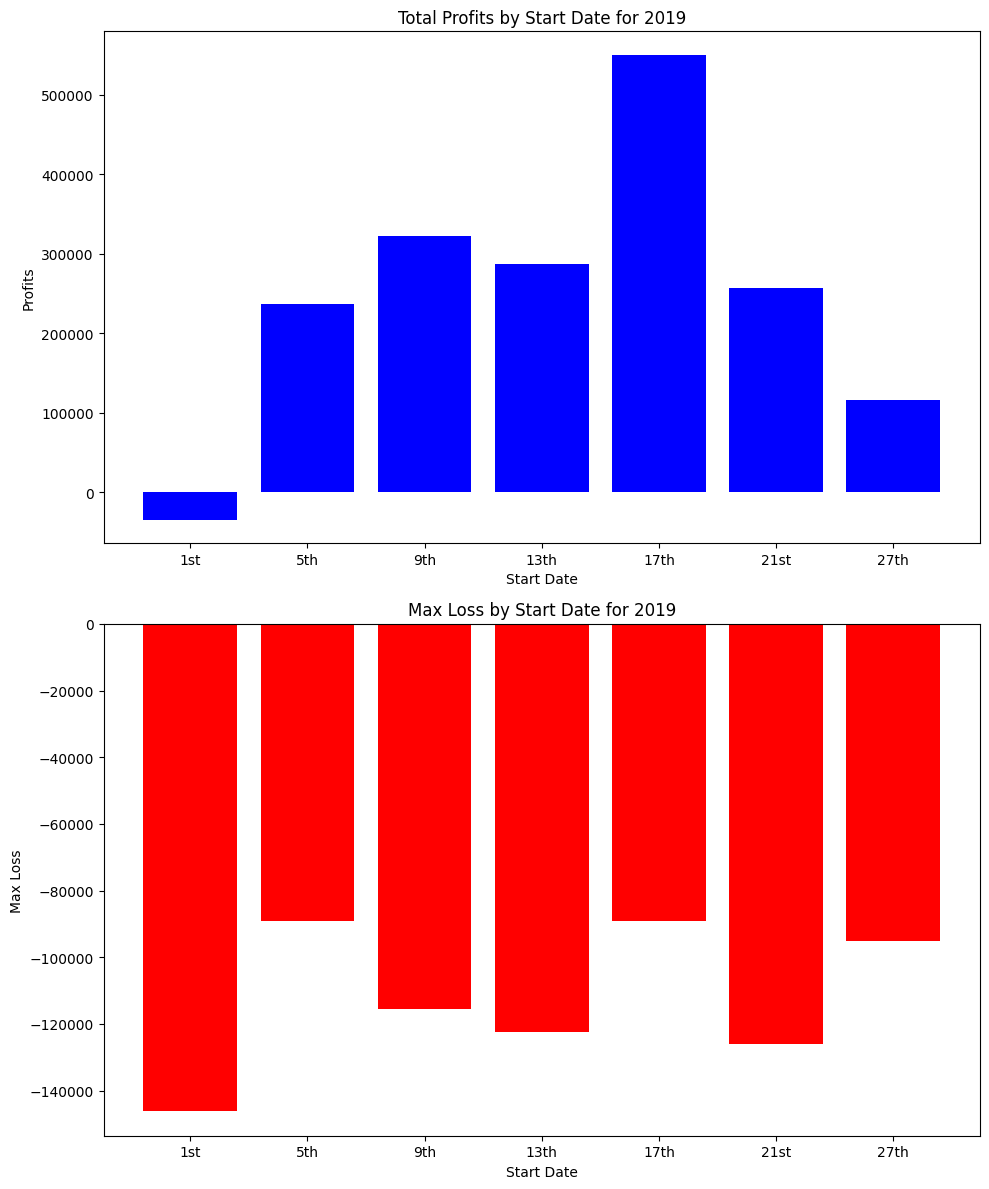

In [77]:
profits = [np.sum(result['profit']) for result in [result_1st, result_5th, result_9th, result_13th, result_17th, result_21st, result_27th]]
max_losses = [min(np.min(np.cumsum(result['profit'])),np.min(result['max_loss'])) for result in [result_1st, result_5th, result_9th, result_13th, result_17th, result_21st, result_27th]]

dates = ['1st', '5th', '9th', '13th', '17th', '21st', '27th']

# Creating the subplots
fig, axs = plt.subplots(2, figsize=(10, 12))

# Plotting the sum of profits
bars1 = axs[0].bar(dates, profits, color='blue')
axs[0].set_title('Total Profits by Start Date for 2019')
axs[0].set_xlabel('Start Date')
axs[0].set_ylabel('Profits')

# Plotting the minimum of max_loss
bars2 = axs[1].bar(dates, max_losses, color='red')
axs[1].set_title('Max Loss by Start Date for 2019')
axs[1].set_xlabel('Start Date')
axs[1].set_ylabel('Max Loss')

# Displaying the charts
plt.tight_layout()
plt.show()


In [88]:
from GA_optimiser import *

In [78]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]
multiplier_params = [1,3,0.1]
lookback_params = [9,20,30,50,100,150,200]

n_grid_params = ((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = ((lot_params[1]-lot_params[0])/lot_params[2])
n_multiplier_params = ((multiplier_params[1]-multiplier_params[0])/multiplier_params[2])
n_lookback_params = len(lookback_params)

n_combination = n_grid_params*n_lot_params*n_multiplier_params*n_lookback_params

print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('number of multiplier params:-',(n_multiplier_params))
print('number of lookback params:-',(n_lookback_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params*n_multiplier_params*n_lookback_params))


# Adjust these parameter according to search space
n_trials = 50 #NGEN
npop = 100
early_stopping_gen = n_trials # no early stopping
optimizer_param = [n_trials, npop, early_stopping_gen]
parameters = [grid_params,lot_params,multiplier_params,lookback_params]

number of grid params:- 18.0
number of lot params:- 19.0
number of multiplier params:- 20.0
number of lookback params:- 7
total_number_of_combinations:- 47880.0


In [79]:
result_1st = walk_forward_analysis('jan 2020','jan 2021',1,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_5th =  walk_forward_analysis('jan 2020','jan 2021',5,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_9th = walk_forward_analysis('jan 2020','jan 2021',9,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_13th = walk_forward_analysis('jan 2020','jan 2021',13,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_17th = walk_forward_analysis('jan 2020','jan 2021',17,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_21st = walk_forward_analysis('jan 2020','jan 2021',21,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_27th = walk_forward_analysis('jan 2020','jan 2021',27,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)

Data gathered for training period:  01 Oct 2019 31 Dec 2019
Data gathered for testing period:  01 Jan 2020 31 Jan 2020
optimisation completed
Optimal parameters are:  [0.007, 2000000, 1.7, 50]
Max loss,R_PNL,profit are:  -60838.0 11900.0 -60838.0
Data gathered for training period:  01 Nov 2019 31 Jan 2020
Data gathered for testing period:  01 Feb 2020 29 Feb 2020
optimisation completed
Optimal parameters are:  [0.0055, 1300000, 2.3, 30]
Max loss,R_PNL,profit are:  -110825.0 -37180.0 -63664.8863
Data gathered for training period:  01 Dec 2019 29 Feb 2020
Data gathered for testing period:  01 Mar 2020 31 Mar 2020
optimisation completed
Optimal parameters are:  [0.002, 1000000, 2.6, 20]
Max loss,R_PNL,profit are:  -35840.0 69669.0281 68388.0
Data gathered for training period:  01 Jan 2020 31 Mar 2020
Data gathered for testing period:  01 Apr 2020 30 Apr 2020
optimisation completed
Optimal parameters are:  [0.002, 900000, 2.7, 100]
Max loss,R_PNL,profit are:  -27000.0 65858.9882 53814.6
Da

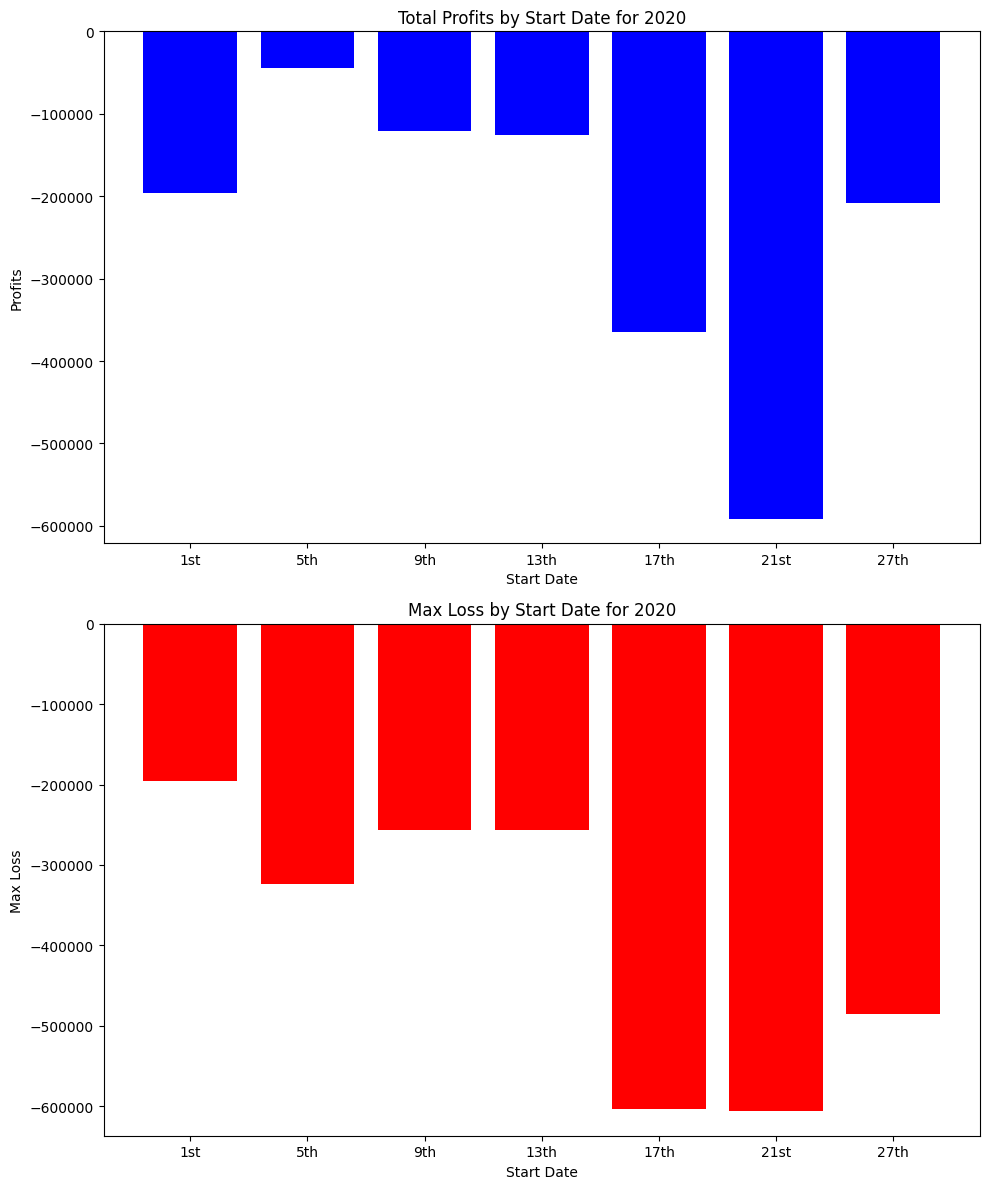

In [80]:
profits = [np.sum(result['profit']) for result in [result_1st, result_5th, result_9th, result_13th, result_17th, result_21st, result_27th]]
max_losses = [min(np.min(np.cumsum(result['profit'])),np.min(result['max_loss'])) for result in [result_1st, result_5th, result_9th, result_13th, result_17th, result_21st, result_27th]]

dates = ['1st', '5th', '9th', '13th', '17th', '21st', '27th']

# Creating the subplots
fig, axs = plt.subplots(2, figsize=(10, 12))

# Plotting the sum of profits
bars1 = axs[0].bar(dates, profits, color='blue')
axs[0].set_title('Total Profits by Start Date for 2020')
axs[0].set_xlabel('Start Date')
axs[0].set_ylabel('Profits')

# Plotting the minimum of max_loss
bars2 = axs[1].bar(dates, max_losses, color='red')
axs[1].set_title('Max Loss by Start Date for 2020')
axs[1].set_xlabel('Start Date')
axs[1].set_ylabel('Max Loss')

# Displaying the charts
plt.tight_layout()
plt.show()


In [81]:
result_1st = walk_forward_analysis('jan 2021','jan 2022',1,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_5th =  walk_forward_analysis('jan 2021','jan 2022',5,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_9th = walk_forward_analysis('jan 2021','jan 2022',9,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_13th = walk_forward_analysis('jan 2021','jan 2022',13,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_17th = walk_forward_analysis('jan 2021','jan 2022',17,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_21st = walk_forward_analysis('jan 2021','jan 2022',21,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)
result_27th = walk_forward_analysis('jan 2021','jan 2022',27,parameters,optimization_function=deap_optimiser_multiplier,optimizer_params=optimizer_param,lookback_in_months=3,evaluation_period=1)

Data gathered for training period:  01 Oct 2020 31 Dec 2020
Data gathered for testing period:  01 Jan 2021 31 Jan 2021
optimisation completed
Optimal parameters are:  [0.006, 600000, 2.6, 50]
Max loss,R_PNL,profit are:  -29721.6 22094.4 24997.44
Data gathered for training period:  01 Nov 2020 31 Jan 2021
Data gathered for testing period:  01 Feb 2021 28 Feb 2021
optimisation completed
Optimal parameters are:  [0.009, 1200000, 2.8, 20]
Max loss,R_PNL,profit are:  -8640.0 32400.0 15768.0
Data gathered for training period:  01 Dec 2020 28 Feb 2021
Data gathered for testing period:  01 Mar 2021 31 Mar 2021
optimisation completed
Optimal parameters are:  [0.002, 1200000, 2.7, 20]
Max loss,R_PNL,profit are:  -109224.0 -88141.3403 -107096.4
Data gathered for training period:  01 Jan 2021 31 Mar 2021
Data gathered for testing period:  01 Apr 2021 30 Apr 2021
optimisation completed
Optimal parameters are:  [0.004, 200000, 2.6, 20]
Max loss,R_PNL,profit are:  -22340.0 -9236.8254 -22340.0
Data ga

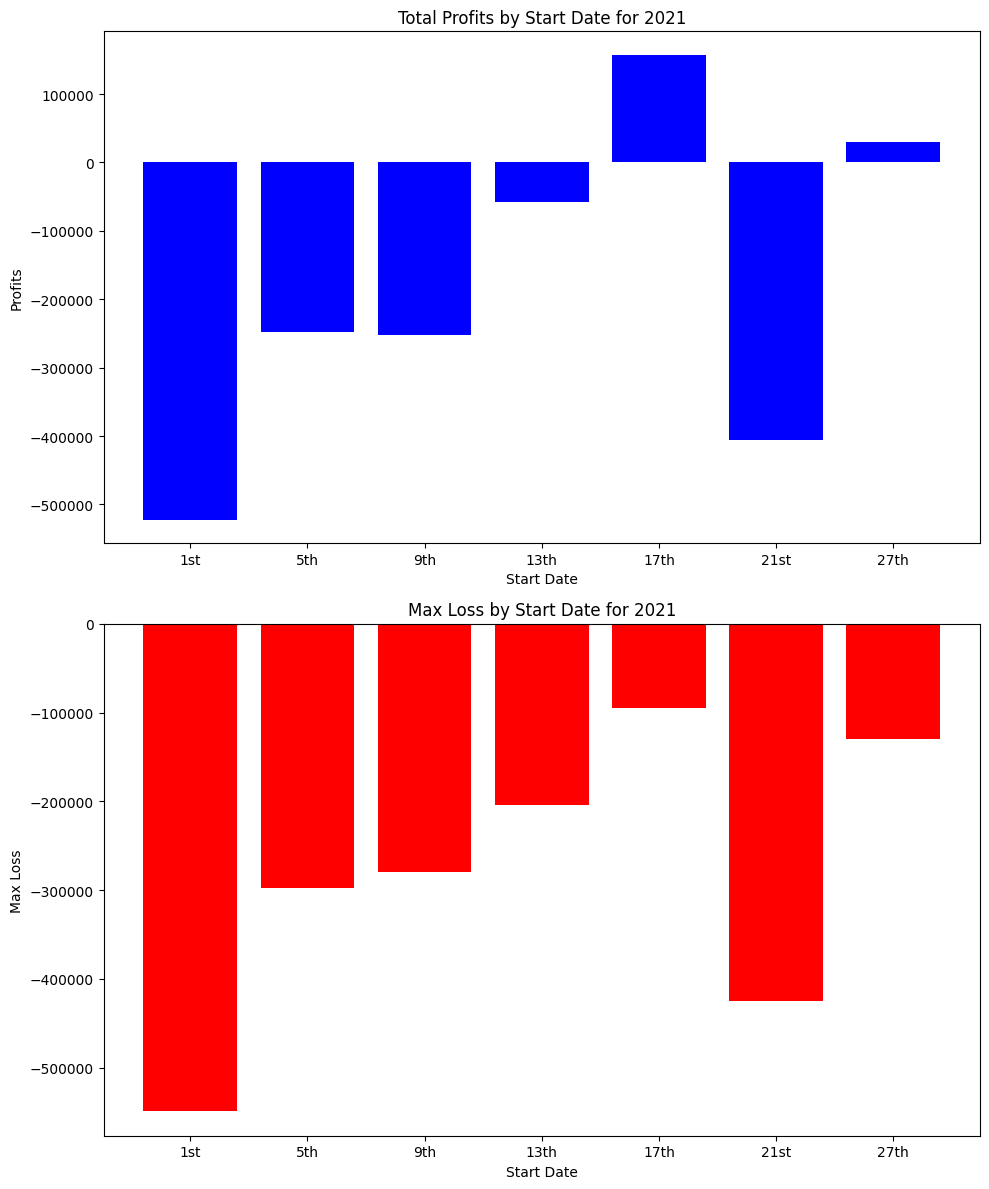

In [82]:
profits = [np.sum(result['profit']) for result in [result_1st, result_5th, result_9th, result_13th, result_17th, result_21st, result_27th]]
max_losses = [min(np.min(np.cumsum(result['profit'])),np.min(result['max_loss'])) for result in [result_1st, result_5th, result_9th, result_13th, result_17th, result_21st, result_27th]]

dates = ['1st', '5th', '9th', '13th', '17th', '21st', '27th']

# Creating the subplots
fig, axs = plt.subplots(2, figsize=(10, 12))

# Plotting the sum of profits
bars1 = axs[0].bar(dates, profits, color='blue')
axs[0].set_title('Total Profits by Start Date for 2021')
axs[0].set_xlabel('Start Date')
axs[0].set_ylabel('Profits')

# Plotting the minimum of max_loss
bars2 = axs[1].bar(dates, max_losses, color='red')
axs[1].set_title('Max Loss by Start Date for 2021')
axs[1].set_xlabel('Start Date')
axs[1].set_ylabel('Max Loss')

# Displaying the charts
plt.tight_layout()
plt.show()

## stationary analysis

In [40]:
def get_date_pairs_(start_date_str,end_date_str,date_format='%d %b %Y',interval = 1):
    # Parse the start and end dates
    start_date = datetime.strptime(start_date_str, date_format)
    end_date = datetime.strptime(end_date_str, date_format)

    # Initialize an empty list to hold the interval pairs
    interval_list = []

    # Increment by one month until we reach or surpass the end date
    current_date = start_date
    next_date = current_date + relativedelta(months=interval)
    while next_date <= end_date:
        interval_list.append((current_date.strftime(date_format), next_date.strftime(date_format)))
        current_date = next_date
        next_date += relativedelta(months=interval)

    # Add the remaining interval if there are extra days left
    if current_date != end_date:
        interval_list.append((current_date.strftime(date_format), end_date.strftime(date_format)))
        
    return interval_list

In [41]:
get_date_pairs_('1 jan 2020','31 dec 2021',interval = 3)

[('01 Jan 2020', '01 Apr 2020'),
 ('01 Apr 2020', '01 Jul 2020'),
 ('01 Jul 2020', '01 Oct 2020'),
 ('01 Oct 2020', '01 Jan 2021'),
 ('01 Jan 2021', '01 Apr 2021'),
 ('01 Apr 2021', '01 Jul 2021'),
 ('01 Jul 2021', '01 Oct 2021'),
 ('01 Oct 2021', '31 Dec 2021')]

In [42]:
def grid_search_optimiser_fixed_period(train_start,train_end,test_start,test_end,parameters, optimization_params = [1000], position_turnover=1):
    train_pairs = get_date_pairs_(train_start, train_end, interval = position_turnover)
    test_pairs = get_date_pairs_(test_start, test_end, interval = position_turnover)
    
    error_check(parameters,2)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    
    ladder_sizing_grid = np.arange(grid_params[0],grid_params[1],grid_params[2])
    lot_sizing_grid = np.arange(position_params[0],position_params[1],position_params[2])
    
    max_profit = -np.inf
    optimal_g = 0
    optimal_n = 0
    

    for ladder_size in ladder_sizing_grid:
        for lot_size in lot_sizing_grid:
            combination_profit = 0
            for pair in train_pairs:
                train_data = data_gather_from_files(pair[0],pair[1])['EURUSD.mid']
                max_loss, R_PNL, profit = run_strategy_optimised(train_data, ladder_size, lot_size)
                if (max_loss > -500000):
                    combination_profit += profit
                else:
                    combination_profit = -np.inf
            if combination_profit > max_profit:
                optimal_g = ladder_size
                optimal_n = lot_size

    print("optimisation completed")
    df = {}
    for pair in test_pairs:
        tick_data = data_gather_from_files(pair[0],pair[1])['EURUSD.mid']
        max_loss, R_PNL,profit = run_strategy_optimised(tick_data, optimal_g,optimal_n)
        df[pair[0] +'-'+ pair[1]] = [max_loss, R_PNL,profit,optimal_g,optimal_n]
    df = pd.DataFrame(df).T
    df.columns = ['max_loss', 'R_PNL','profit','optimal_g','optimal_n']
    return df

In [43]:
grid_search_fixed = grid_search_optimiser_fixed_period('1 jan 2014','31 dec 2019','1 jan 2020','31 dec 2021',[[0.001,0.01,0.0005],[100000,2000000,100000]], position_turnover=1)

KeyboardInterrupt: 

In [ ]:
grid_search_fixed

,max_loss,R_PNL,profit,optimal_g,optimal_n
01 Jan 2020-01 Feb 2020,-54150.00000,-3800.00000,-11400.00000,0.00950,1900000.00000
01 Feb 2020-01 Mar 2020,0.00000,54150.00000,54150.00000,0.00950,1900000.00000
01 Mar 2020-01 Apr 2020,-72200.00000,216599.99990,216600.00000,0.00950,1900000.00000
01 Apr 2020-01 May 2020,-90250.00000,26362.50000,43700.00000,0.00950,1900000.00000
01 May 2020-01 Jun 2020,-18050.00000,36100.00000,35910.00000,0.00950,1900000.00000
01 Jun 2020-01 Jul 2020,0.00000,72200.00000,72200.00000,0.00950,1900000.00000
01 Jul 2020-01 Aug 2020,-131950.00000,-113900.00000,-113900.00000,0.00950,1900000.00000
01 Aug 2020-01 Sep 2020,-18050.00000,38356.25000,12540.00000,0.00950,1900000.00000
01 Sep 2020-01 Oct 2020,0.00000,34295.00000,32490.00000,0.00950,1900000.00000
01 Oct 2020-01 Nov 2020,0.00000,36100.00000,28880.00000,0.00950,1900000.00000


In [ ]:
print('profit in 2020 = ',grid_search_fixed['profit'][:12].sum())
print('max_loss in 2020 = ',np.min(grid_search_fixed['max_loss'][:12]))
print('profit in 2021 = ',grid_search_fixed['profit'][12:].sum())
print('max_loss in 2021 = ',np.min(grid_search_fixed['max_loss'][12:]))

profit in 2020 =  280730.0
max_loss in 2020 =  -131950.0
profit in 2021 =  4940.0
max_loss in 2021 =  -130530.0


In [ ]:
grid_search_fixed_1 = grid_search_optimiser_fixed_period('1 jan 2014','31 dec 2019','1 jan 2020','31 dec 2021',[[0.001,0.01,0.0005],[100000,2000000,100000]], position_turnover=3)
print('profit = ',grid_search_fixed_1['profit'].sum())
print('max_loss = ',np.min(grid_search_fixed_1['max_loss']))

optimisation completed
profit =  -398922.5
max_loss =  -400362.5


In [ ]:
grid_search_fixed_1

,max_loss,R_PNL,profit,optimal_g,optimal_n
01 Jan 2020-01 Apr 2020,-400362.50000,-310112.50000,-312392.50000,0.00950,1900000.00000
01 Apr 2020-01 Jul 2020,-90250.00000,144400.00010,157890.00000,0.00950,1900000.00000
01 Jul 2020-01 Oct 2020,-131950.00000,1620.00000,1620.00000,0.00950,1900000.00000
01 Oct 2020-01 Jan 2021,-86825.00000,-50725.00000,-50725.00000,0.00950,1900000.00000
01 Jan 2021-01 Apr 2021,-40280.00000,90250.00000,-40280.00000,0.00950,1900000.00000
01 Apr 2021-01 Jul 2021,-249275.00000,-150000.00000,-245665.00000,0.00950,1900000.00000
01 Jul 2021-01 Oct 2021,0.00000,72200.00000,48070.00000,0.00950,1900000.00000
01 Oct 2021-31 Dec 2021,-18050.00000,39330.00000,42560.00000,0.00950,1900000.00000


In [ ]:
print('profit in 2020 = ',grid_search_fixed_1['profit'][:4].sum())
print('max_loss in 2020 = ',np.min(grid_search_fixed_1['max_loss'][:4]))
print('profit in 2021 = ',grid_search_fixed_1['profit'][4:].sum())
print('max_loss in 2021 = ',np.min(grid_search_fixed_1['max_loss'][4:]))

profit in 2020 =  -203607.5
max_loss in 2020 =  -400362.5
profit in 2021 =  -195315.0
max_loss in 2021 =  -249275.0


In [ ]:
def optuna_optimiser_multiplier_fixed_period(train_start,train_end,test_start,test_end,parameters, optimization_params = [1000], position_turnover=1):
    train_pairs = get_date_pairs(train_start, train_end, interval = position_turnover)
    test_pairs = get_date_pairs(test_start, test_end, interval = position_turnover)
    n_trials = optimization_params[0]

    error_check(parameters,4)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    multiplier_params = parameters[2]
    lookback_params = parameters[3]
    
    def objective_optuna(trial, train_pairs):
        #G = trial.suggest_int("G", grid_params[0]/grid_params[2], grid_params[1]/grid_params[2])*grid_params[2]
        #n = trial.suggest_int("n", position_params[0]/position_params[2], position_params[1]/position_params[2])*position_params[2]
        multiplier = trial.suggest_int("multiplier", multiplier_params[0]/multiplier_params[2], multiplier_params[1]/multiplier_params[2])*multiplier_params[2]
        lookback = trial.suggest_categorical("lookback", lookback_params)
        G = 0.0095
        n = 1900000
        
        total_profit = 0
        for pair in train_pairs:
            tick_data = data_gather_from_files(pair[0],pair[1])['EURUSD.mid']
            max_loss,R_PNL,profit = run_strategy_optimised(tick_data, G, n, multiplier = multiplier,lookback = lookback)
            # Constraints
            if max_loss < -500e3:
                return float('inf')
            total_profit -= profit # We negate the value since we want to maximize Profit
        return total_profit

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective_optuna(trial,train_pairs), n_trials=n_trials)
    
    #optimal_g = np.round(study.best_params["G"]*grid_params[2],5)
    #optimal_n = study.best_params["n"]*position_params[2]
    optimal_g = 0.0095
    optimal_n = 1900000
    optimal_m = study.best_params["multiplier"]*multiplier_params[2]
    optimal_l = study.best_params["lookback"]
    
    print("optimisation completed")
    df = {}
    for pair in test_pairs:
        tick_data = data_gather_from_files(pair[0],pair[1])['EURUSD.mid']
        max_loss, R_PNL,profit = run_strategy_optimised(tick_data, optimal_g,optimal_n,multiplier = optimal_m,lookback = optimal_l)
        df[pair[0] +'-'+ pair[1]] = [max_loss, R_PNL,profit,optimal_g,optimal_n,optimal_m,optimal_l]
    df = pd.DataFrame(df).T
    df.columns = ['max_loss', 'R_PNL','profit','optimal_g','optimal_n','optimal_m','optimal_l']
    return df

In [ ]:
fixed_df = optuna_optimiser_multiplier_fixed_period('1 jan 2018','31 dec 2018','1 jan 2020','31 dec 2021',parameters1,optimization_params=[500],position_turnover=1)

optimisation completed


In [ ]:
fixed_df

,max_loss,R_PNL,profit,optimal_g,optimal_n,optimal_m,optimal_l
01 Jan 2020-01 Feb 2020,-54150.00000,-8740.00000,-11400.00000,0.00950,1900000.00000,2.30000,150.00000
01 Feb 2020-01 Mar 2020,-46930.00000,30685.00000,24979.30000,0.00950,1900000.00000,2.30000,150.00000
01 Mar 2020-01 Apr 2020,-166285.97560,-147095.97560,-146753.97560,0.00950,1900000.00000,2.30000,150.00000
01 Apr 2020-01 May 2020,-54150.00000,14155.00000,14155.00000,0.00950,1900000.00000,2.30000,150.00000
01 May 2020-01 Jun 2020,-18050.00000,18050.00000,-11267.00000,0.00950,1900000.00000,2.30000,150.00000
01 Jun 2020-01 Jul 2020,-46930.00000,30685.00000,50247.40000,0.00950,1900000.00000,2.30000,150.00000
01 Jul 2020-01 Aug 2020,-150000.00000,-113900.00000,-113900.00000,0.00950,1900000.00000,2.30000,150.00000
01 Aug 2020-01 Sep 2020,-18050.00000,26999.00000,26999.00000,0.00950,1900000.00000,2.30000,150.00000
01 Sep 2020-01 Oct 2020,-5415.00000,32490.00000,32490.00000,0.00950,1900000.00000,2.30000,150.00000
01 Oct 2020-01 Nov 2020,-5415.00000,36100.00000,36100.00000,0.00950,1900000.00000,2.30000,150.00000


## optimal_grid_sizing w.r.t to volatility

In [83]:
def macro_indicator_df(start_month_year, end_month_year, day=15, n_months = 1,parameters = parameters2,optimization_function = optuna_optimiser_multiplier, optimizer_params = [1000]):
    generated_date_ranges = generate_date_ranges_for_walk_forward(start_month_year, end_month_year,day,n_months = n_months)
    df = {}
    for dates in generated_date_ranges:
        data = data_gather_from_files(dates[0],dates[1])
        print('Data gathered for period: ',dates[0],dates[1])
        candle_df = tick_to_ohlc(data,'1D')
        data = data['EURUSD.mid']
        average_daily_range = np.mean(np.abs(candle_df['high'] - candle_df['low']))*10000
        print('Average daily range(pips) is: ',average_daily_range)
        volatility = np.std(candle_df['close'].pct_change())*np.sqrt(252)*100
        print('annualised volatility is: ',volatility)
        total_returns = (candle_df['close'].iloc[-1]-candle_df['close'].iloc[0])*10000
        max_loss,R_PNL,profit,optimal_params = optimization_function(data,data,parameters,optimizer_params)
        print('Max loss,R_PNL,profit are: ',max_loss, R_PNL,profit)
        if optimization_function == optuna_optimiser_multiplier:
            df[dates[0] +'-'+ dates[1]] = [max_loss, R_PNL,profit,optimal_params[0],optimal_params[1],optimal_params[2],optimal_params[3],average_daily_range,volatility,total_returns]
        elif optimization_function == Grid_Search:
            df[dates[0] +'-'+ dates[1]] = [max_loss, R_PNL,profit,optimal_params[0],optimal_params[1],average_daily_range,volatility,total_returns]
        else:
            None
    df = pd.DataFrame(df).T
    if optimization_function == optuna_optimiser_multiplier:
        df.columns = ['max_loss', 'R_PNL','profit','grid_size','lot_size','multiplier','lookback','average_daily_range','volatility','total_returns']
    elif optimization_function == Grid_Search:
        df.columns = ['max_loss', 'R_PNL','profit','grid_size','lot_size','average_daily_range','volatility','total_returns']
    else:
        None
    return df

In [84]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]

n_grid_params = ((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = ((lot_params[1]-lot_params[0])/lot_params[2])

print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params))

n_trials = 300
optimizer_param = [n_trials]

print('search_space_explored:-',(n_trials/(n_grid_params*n_lot_params))*100,'%')

parameters = [grid_params,lot_params]

number of grid params:- 18.0
number of lot params:- 19.0
total_number_of_combinations:- 342.0
search_space_explored:- 87.71929824561403 %


In [86]:
stats_grid_df = macro_indicator_df('jan 2014','jan 2022',1,1,parameters = parameters,optimization_function = Grid_Search, optimizer_params = [])

Data gathered for period:  01 Jan 2014 31 Jan 2014
Average daily range(pips) is:  70.49634121358395
annualised volatility is:  5.981659164984315
Max loss,R_PNL,profit are:  -58800.0 92400.0002 83160.0
Data gathered for period:  01 Feb 2014 28 Feb 2014
Average daily range(pips) is:  58.16522054374218
annualised volatility is:  3.993684027623038
Max loss,R_PNL,profit are:  -37800.0 59399.9998 59400.0
Data gathered for period:  01 Mar 2014 31 Mar 2014
Average daily range(pips) is:  64.99390583485365
annualised volatility is:  4.979728737824489
Max loss,R_PNL,profit are:  -24500.0 105349.9998 107520.0
Data gathered for period:  01 Apr 2014 30 Apr 2014
Average daily range(pips) is:  47.84607794135809
annualised volatility is:  3.091999755732171
Max loss,R_PNL,profit are:  -1500.0 88700.0005 88700.0
Data gathered for period:  01 May 2014 31 May 2014
Average daily range(pips) is:  48.938533291220665
annualised volatility is:  3.3988744400812285
Max loss,R_PNL,profit are:  -18050.0 36100.0 273

In [ ]:
grid_params = [0.001,0.01,0.0005]
lot_params = [100000,2000000,100000]
multiplier_params = [1,3,0.1]
lookback_params = [9,20,30,50,100,150,200]

n_grid_params = ((grid_params[1]-grid_params[0])/grid_params[2])
n_lot_params = ((lot_params[1]-lot_params[0])/lot_params[2])
n_multiplier_params = ((multiplier_params[1]-multiplier_params[0])/multiplier_params[2])
n_lookback_params = len(lookback_params)

n_combination = n_grid_params*n_lot_params*n_multiplier_params*n_lookback_params

print('number of grid params:-',(n_grid_params))
print('number of lot params:-',(n_lot_params))
print('number of multiplier params:-',(n_multiplier_params))
print('number of lookback params:-',(n_lookback_params))
print('total_number_of_combinations:-',(n_grid_params*n_lot_params*n_multiplier_params*n_lookback_params))


# Adjust these parameter according to search space
n_trials = 50 #NGEN
npop = 100
early_stopping_gen = n_trials # no early stopping
optimizer_param = [n_trials, npop, early_stopping_gen]
parameters = [grid_params,lot_params,multiplier_params,lookback_params]

In [89]:
stats_df = macro_indicator_df('jan 2014','jan 2022',1,1,parameters = parameters,optimization_function = deap_optimiser_multiplier, optimizer_params = optimizer_param)

Data gathered for period:  01 Jan 2014 31 Jan 2014
Average daily range(pips) is:  70.49634121358395
annualised volatility is:  5.981659164984315


IndexError: list index out of range

In [ ]:
stats_grid_df

,max_loss,R_PNL,profit,grid_size,lot_size,average_daily_range,volatility,total_returns
01 Jan 2018-31 Jan 2018,-79200.00000,43839.99970,43840.00000,0.00150,1600000.00000,85.91152,7.23958,397.79902
01 Feb 2018-28 Feb 2018,-25650.00000,180618.75010,154470.00000,0.00450,1900000.00000,88.81522,7.00044,-284.60026
01 Mar 2018-31 Mar 2018,-11400.00000,89300.00000,98230.00000,0.00600,1900000.00000,78.26352,6.98645,51.85127
01 Apr 2018-30 Apr 2018,0.00000,50445.00000,52440.00000,0.00850,1900000.00000,61.39612,4.51902,-190.00053
01 May 2018-31 May 2018,-10400.00000,-94.64280,-4050.00000,0.00650,100000.00000,79.67105,6.93204,-326.44987
01 Jun 2018-30 Jun 2018,-10000.00000,190000.00040,190000.00000,0.00200,1000000.00000,82.62782,8.86272,25.94948
01 Jul 2018-31 Jul 2018,-13600.00000,173400.00020,172210.00000,0.00200,1700000.00000,62.51936,5.09560,28.54943
01 Aug 2018-31 Aug 2018,-53200.00000,97660.00000,97660.00000,0.00700,1900000.00000,69.17697,6.73245,2.20060
01 Sep 2018-30 Sep 2018,0.00000,117600.00000,117600.00000,0.00350,1600000.00000,70.45612,6.05732,5.39899
01 Oct 2018-31 Oct 2018,-33150.00000,55462.50010,39100.00000,0.00150,1700000.00000,65.44031,5.12970,-231.65107


In [ ]:
stats_df

,max_loss,R_PNL,profit,grid_size,lot_size,multiplier,lookback,average_daily_range,volatility,total_returns
01 Jan 2017-31 Jan 2017,-35074.00000,227124.94460,283974.00000,0.00650,1900000.00000,2.20000,100.00000,79.98077,7.45780,182.10053
01 Feb 2017-28 Feb 2017,-17000.00000,211559.99980,214120.00000,0.00250,1600000.00000,2.50000,200.00000,62.49998,4.93401,-181.44965
01 Mar 2017-31 Mar 2017,0.00000,234650.00000,225910.00000,0.00650,1900000.00000,2.00000,200.00000,64.39796,7.69629,151.69859
01 Apr 2017-30 Apr 2017,0.00000,265581.35690,275120.00000,0.00250,800000.00000,2.00000,200.00000,58.02502,6.61965,226.79925
01 May 2017-31 May 2017,0.00000,162878.75200,302558.20000,0.00800,1400000.00000,2.90000,30.00000,67.78282,7.12412,264.30011
01 Jun 2017-30 Jun 2017,0.00000,182700.00000,278100.00000,0.00750,1800000.00000,2.00000,9.00000,58.93197,6.53724,226.65024
01 Jul 2017-31 Jul 2017,0.00000,244415.87340,370173.12000,0.00650,1200000.00000,2.20000,200.00000,69.01798,6.31560,323.60077
01 Aug 2017-31 Aug 2017,-7296.00000,280896.00000,254171.36000,0.00600,1900000.00000,1.80000,150.00000,80.16371,6.65702,79.69975
01 Sep 2017-30 Sep 2017,0.00000,219034.37500,318670.31250,0.00950,1700000.00000,1.50000,100.00000,75.77987,6.59347,-45.29953
01 Oct 2017-31 Oct 2017,-12800.00000,102400.00000,200680.00000,0.00800,1600000.00000,2.50000,150.00000,62.42491,6.89505,-156.79955


In [ ]:
stats_df.describe()

,max_loss,R_PNL,profit,grid_size,lot_size,multiplier,lookback,average_daily_range,volatility,total_returns
count,60.00000,60.00000,60.00000,60.00000,60.00000,60.00000,60.00000,60.00000,60.00000,60.00000
mean,-10503.25200,201674.57576,235318.80833,0.00494,1560000.00000,2.18333,88.48333,62.52833,5.65145,15.39671
std,19396.81099,120744.70104,115148.68332,0.00275,458146.59781,0.56393,72.41980,17.38937,1.70770,197.77451
min,-85000.00000,61740.00000,102000.00000,0.00100,300000.00000,1.00000,9.00000,33.24404,2.62050,-326.44987
25%,-12900.00000,139012.23573,179707.07250,0.00287,1300000.00000,1.80000,20.00000,53.06904,4.89540,-119.42416
50%,-140.00000,180652.16865,219484.70000,0.00425,1650000.00000,2.20000,50.00000,62.46244,5.36552,2.87533
75%,0.00000,233039.76042,273175.40000,0.00750,2000000.00000,2.62500,150.00000,69.49676,6.61591,154.31166
max,0.00000,926225.83420,909309.00000,0.01000,2000000.00000,3.00000,200.00000,149.18254,13.88844,620.85152


In [ ]:
import seaborn as sns

/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


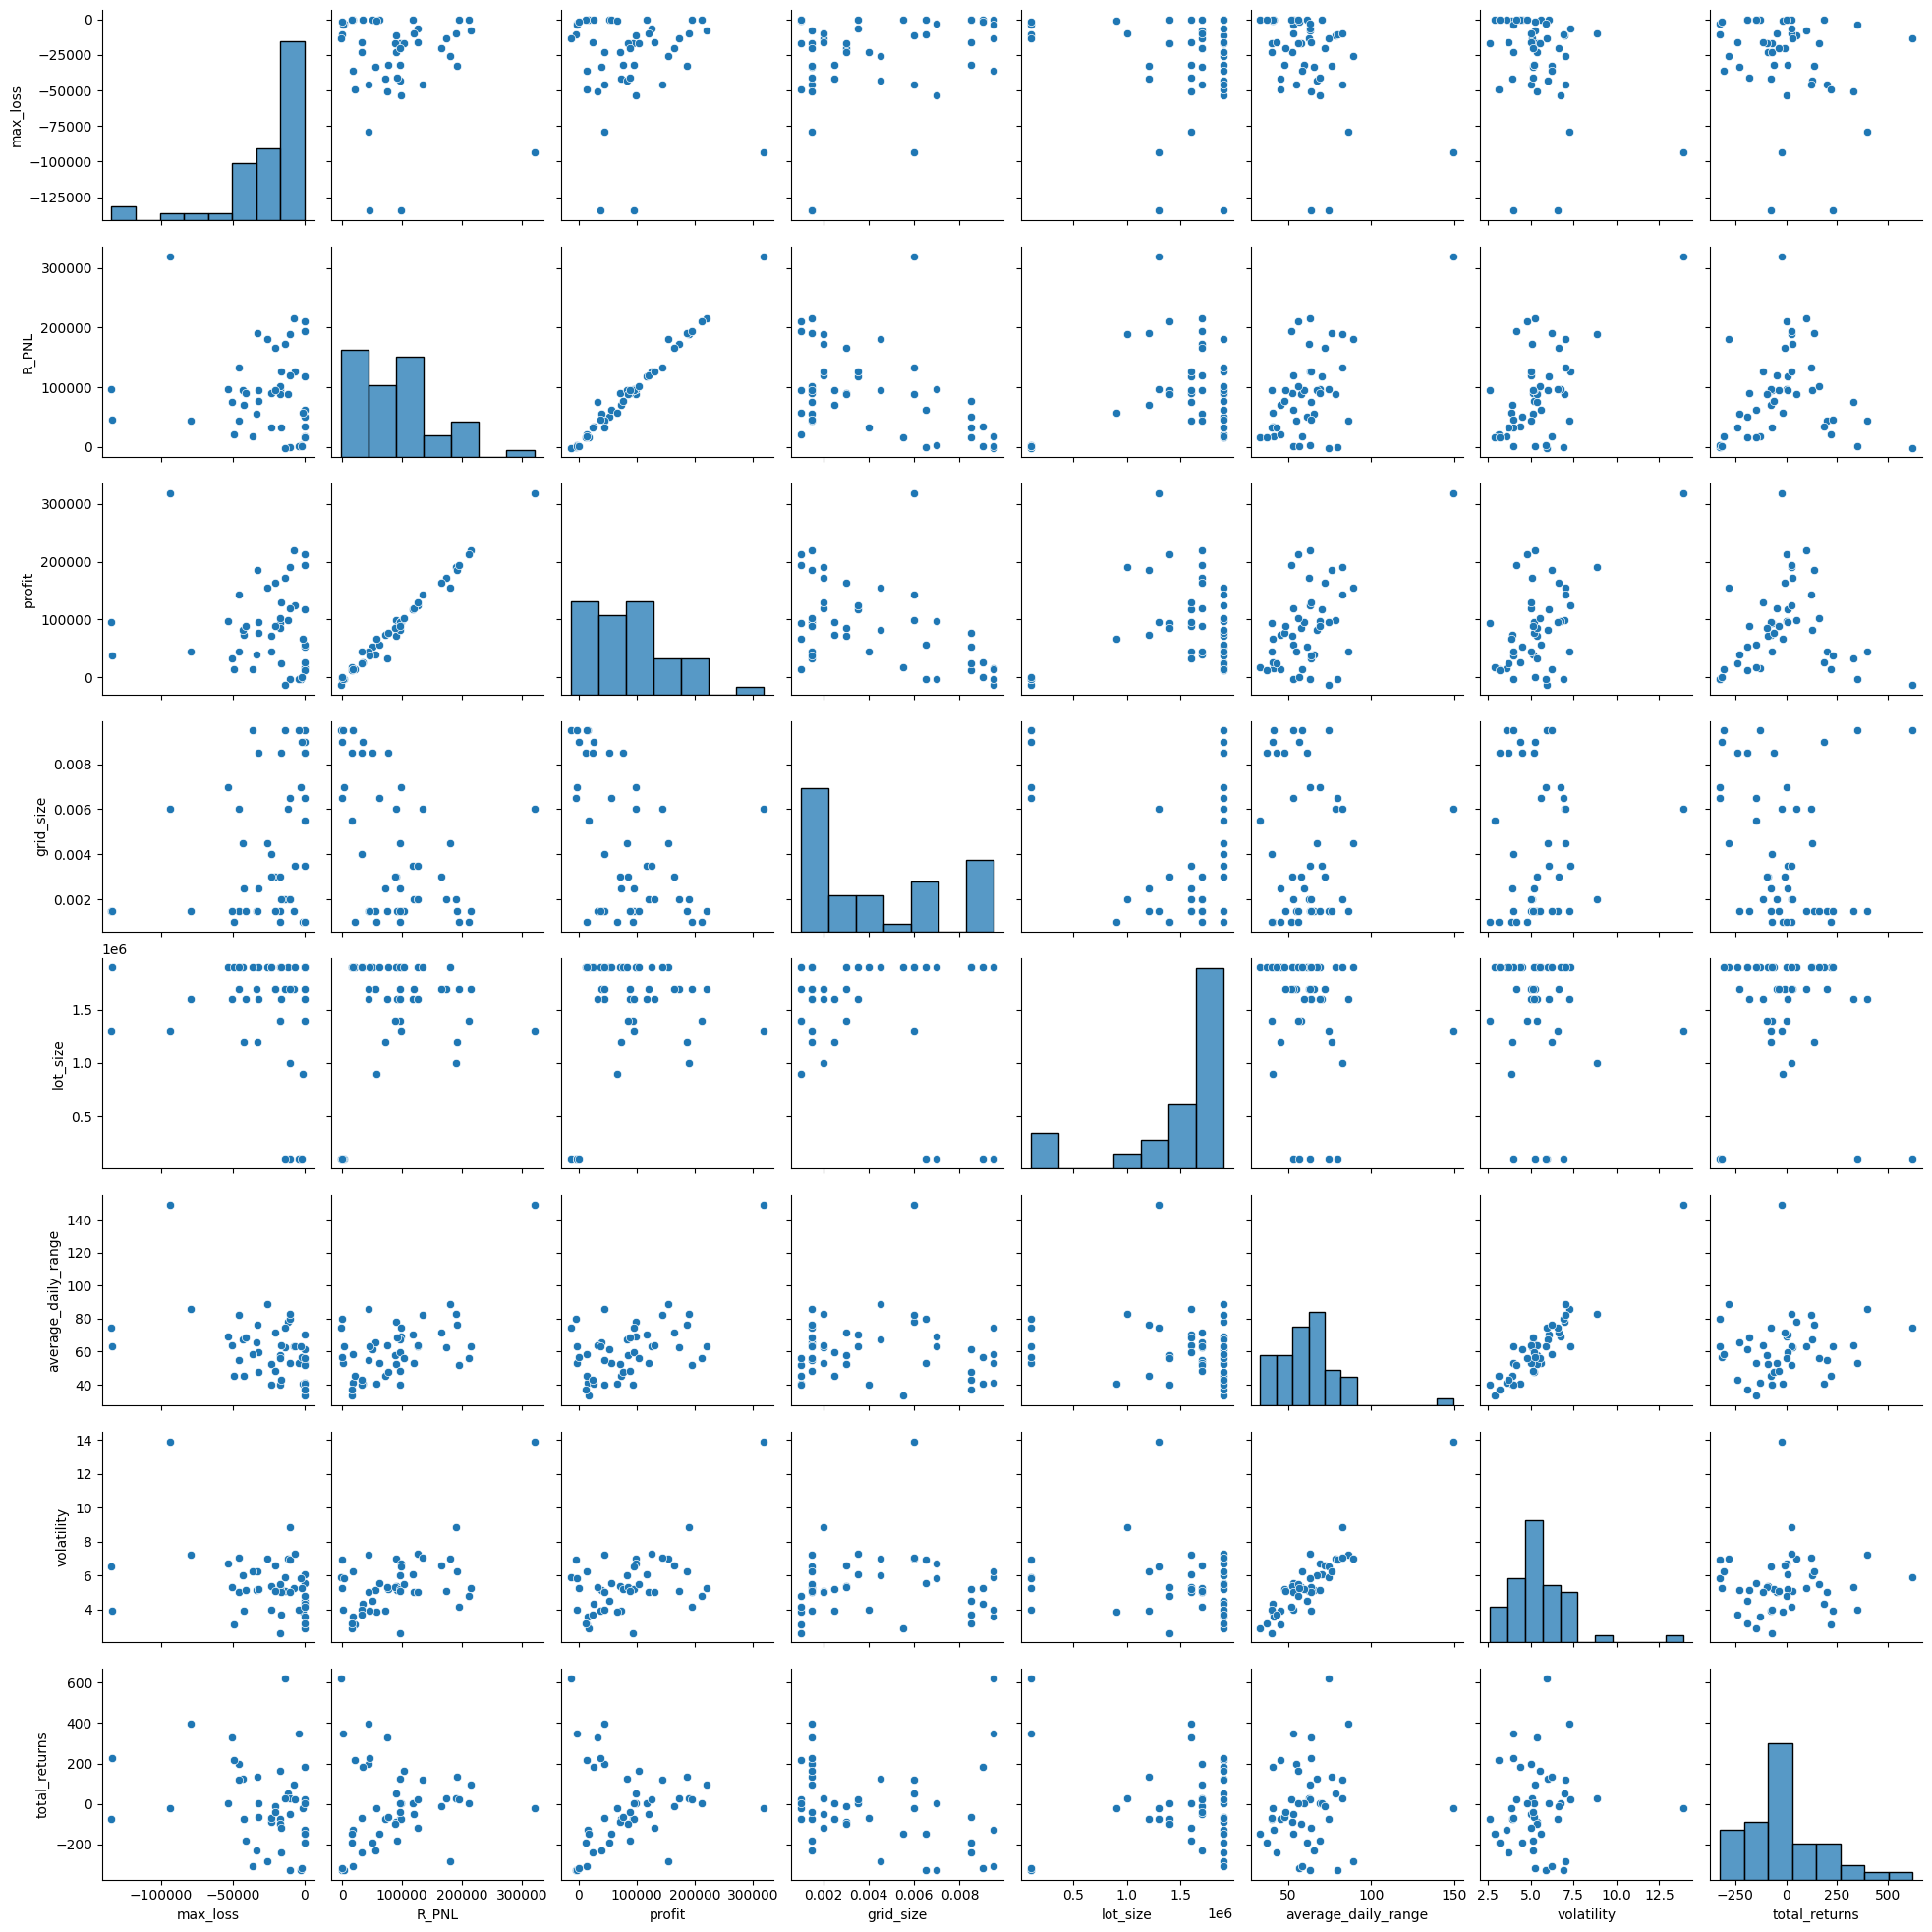

In [ ]:
sns.pairplot(stats_grid_df)

 20%|██        | 70/342 [71:22:48<277:21:46, 3670.98s/it]
/Users/samanvayms/opt/anaconda3/envs/tradingenv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


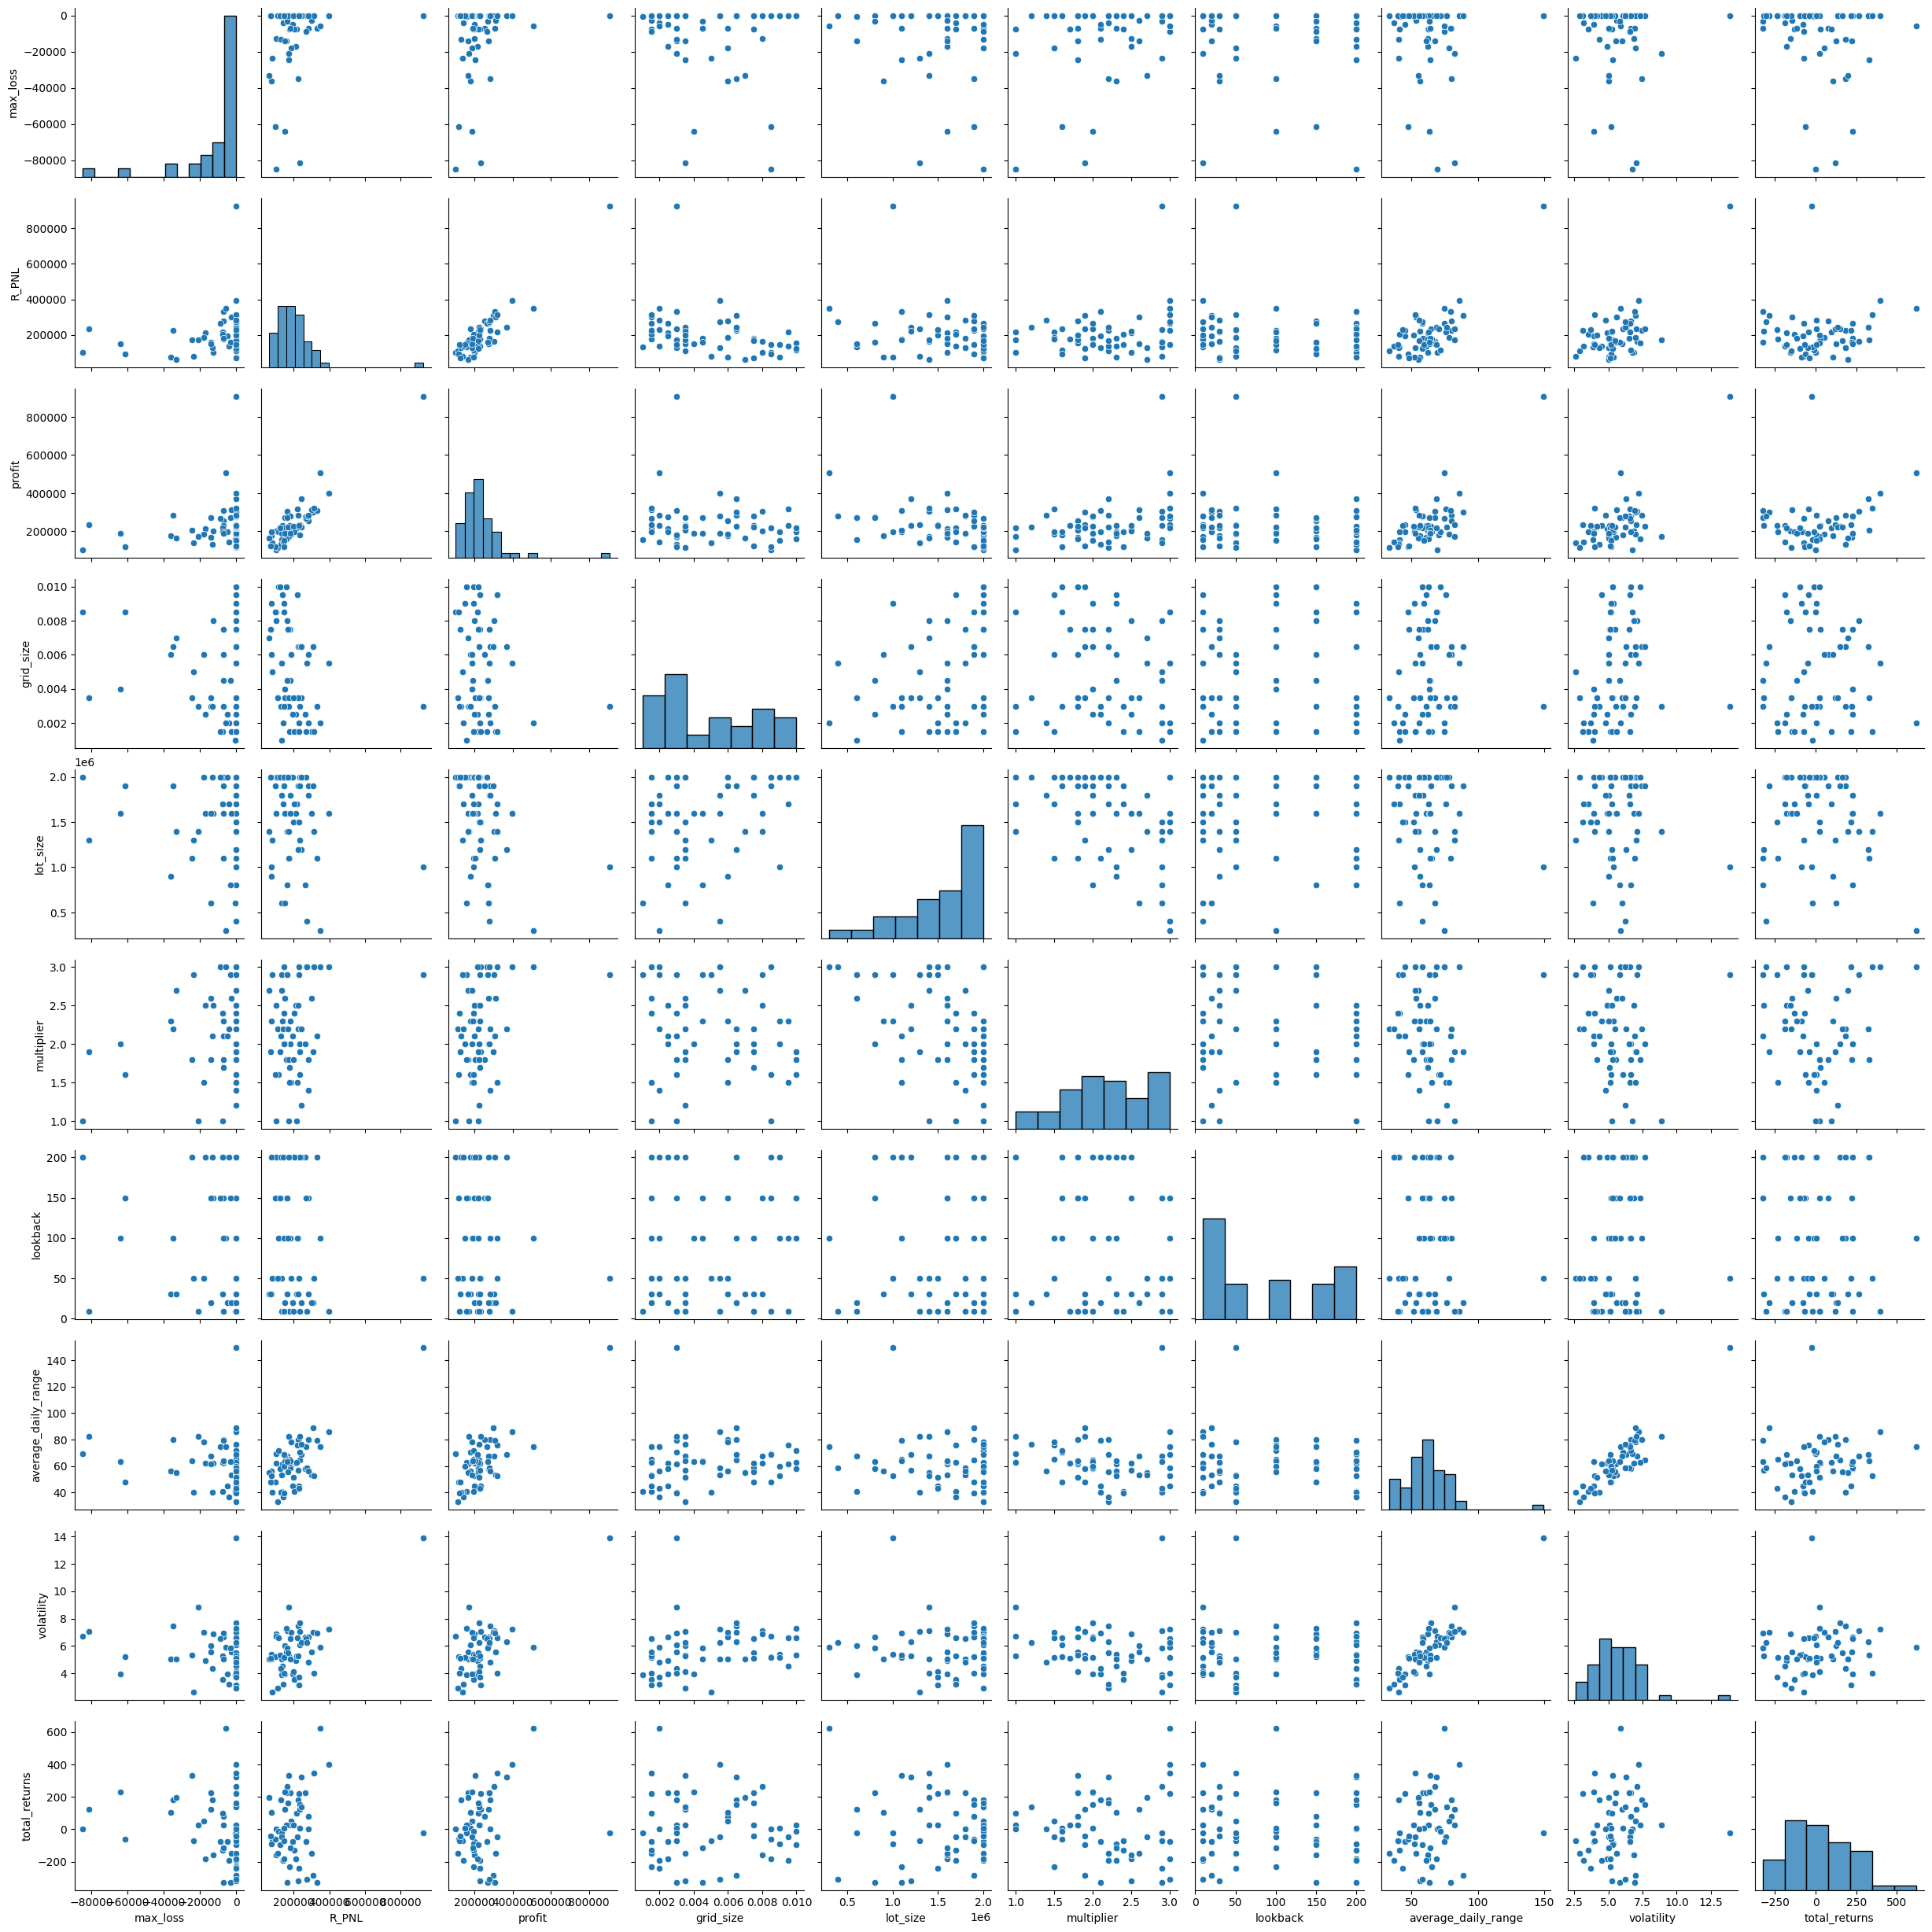

In [ ]:
sns.pairplot(stats_df)

#### new grid based optimisation derived from policy iteration

In [ ]:
def new_search_2(train_start,train_end,test_start,test_end,parameters, position_turnover=1,max_iterations = 10):
    train_pairs = get_date_pairs(train_start, train_end, interval = position_turnover)
    test_pairs = get_date_pairs(test_start, test_end, interval = position_turnover)
    
    error_check(parameters,4)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    multiplier_params = parameters[2]
    lookback_params = parameters[3]
    
    ladder_sizing_grid = np.arange(grid_params[0],grid_params[1],grid_params[2])
    lot_sizing_grid = np.arange(position_params[0],position_params[1],position_params[2])
    multiplier_grid = np.arange(multiplier_params[0],multiplier_params[1],multiplier_params[2])
    lookback_grid = lookback_params
    
    max_profit = -np.inf
    optimal_g = np.random.choice(ladder_sizing_grid)
    optimal_n = np.random.choice(lot_sizing_grid)
    optimal_m = np.random.choice(multiplier_grid)
    optimal_l = np.random.choice(lookback_grid)
    
    for iteration in range(max_iterations):
        optimal_values = np.array([optimal_g,optimal_n,optimal_m,optimal_l])
        if iteration%2 == 1:
            time1 = time.time()
            pbar = tqdm(total=len(ladder_sizing_grid)*len(lot_sizing_grid))
            for ladder_size in ladder_sizing_grid:
                for lot_size in lot_sizing_grid:
                    combination_profit = 0
                    for pair in train_pairs:
                        train_data = data_gather_from_files(pair[0],pair[1])['EURUSD.mid']
                        max_loss, R_PNL, profit = run_strategy_optimised(train_data, grid_sizing=ladder_size, lot_sizing=lot_size, multiplier = optimal_values[2],lookback = optimal_values[3])
                        if (max_loss > -500000):
                            combination_profit += profit
                        else:
                            combination_profit = -np.inf
                    if combination_profit > max_profit:
                        optimal_g = ladder_size
                        optimal_n = lot_size
                        optimal_m = optimal_values[2]
                        optimal_l = optimal_values[3]
                    pbar.update(1)
            pbar.close()
            time2 = time.time()
        else:
            time1 = time.time()
            pbar = tqdm(total=len(lookback_grid)*len(multiplier_grid))
            for multiplier in multiplier_grid:
                for lookback in lookback_grid:
                    combination_profit = 0
                    for pair in train_pairs:
                        train_data = data_gather_from_files(pair[0],pair[1])['EURUSD.mid']
                        max_loss, R_PNL, profit = run_strategy_optimised(train_data, grid_sizing=optimal_values[0], lot_sizing=optimal_values[1], multiplier = multiplier,lookback = lookback)
                        if (max_loss > -500000):
                            combination_profit += profit
                        else:
                            combination_profit = -np.inf
                    if combination_profit > max_profit:
                        optimal_g = optimal_values[0]
                        optimal_n = optimal_values[1]
                        optimal_m = multiplier
                        optimal_l = lookback
                    pbar.update(1)
            pbar.close()
            time2 = time.time()
        print('iteration',iteration,'completed, best parameters are: ',[optimal_g,optimal_n,optimal_m,optimal_l],'time taken:-',time2-time1,'seconds')
        if np.array_equal(optimal_values,np.array([optimal_g,optimal_n,optimal_m,optimal_l])) and iteration > 2:
            break

    print("optimisation completed")
    df = {}
    for pair in test_pairs:
        tick_data = data_gather_from_files(pair[0],pair[1])['EURUSD.mid']
        max_loss, R_PNL,profit = run_strategy_optimised(tick_data, optimal_g,optimal_n,multiplier = optimal_m,lookback = optimal_l)
        df[pair[0] +'-'+ pair[1]] = [max_loss, R_PNL,profit,optimal_g,optimal_n,optimal_m,optimal_l]
    df = pd.DataFrame(df).T
    df.columns = ['max_loss', 'R_PNL','profit','optimal_g','optimal_n','optimal_m','optimal_l']
    return df

In [ ]:
new_search_2('1 jan 2014','31 dec 2019','1 jan 2020','31 dec 2021',parameters1,position_turnover=1,max_iterations=10)















































































































































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 140/140 [14:34<00:00,  6.25s/it]


iteration 0 completed, best parameters are:  [0.007500000000000001, 500000.0, 2.9000000000000017, 200] time taken:- 874.7530188560486 seconds


iteration 1 completed, best parameters are:  [0.009500000000000001, 1900000, 2.9000000000000017, 200.0] time taken:- 2176.122698068619 seconds
















































































































































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 140/140 [14:27<00:00,  6.20s/it]


iteration 2 completed, best parameters are:  [0.009500000000000001, 1900000.0, 2.9000000000000017, 200] time taken:- 867.3529739379883 seconds


iteration 3 completed, best parameters are:  [0.009500000000000001, 1900000, 2.9000000000000017, 200.0] time taken:- 23150.324469804764 seconds
optimisation completed


,max_loss,R_PNL,profit,optimal_g,optimal_n,optimal_m,optimal_l
01 Jan 2020-01 Feb 2020,-54150.00000,-11020.00000,-11400.00000,0.00950,1900000.00000,2.90000,200.00000
01 Feb 2020-01 Mar 2020,-68590.00000,21185.00000,21185.00000,0.00950,1900000.00000,2.90000,200.00000
01 Mar 2020-01 Apr 2020,-72200.00000,104505.00000,104505.00000,0.00950,1900000.00000,2.90000,200.00000
01 Apr 2020-01 May 2020,-54150.00000,16245.00000,-1235.00000,0.00950,1900000.00000,2.90000,200.00000
01 May 2020-01 Jun 2020,-33041.00000,18050.00000,-33041.00000,0.00950,1900000.00000,2.90000,200.00000
01 Jun 2020-01 Jul 2020,-68590.00000,5970.38460,15295.00000,0.00950,1900000.00000,2.90000,200.00000
01 Jul 2020-01 Aug 2020,-186100.00000,-131950.00000,-131950.00000,0.00950,1900000.00000,2.90000,200.00000
01 Aug 2020-01 Sep 2020,-18050.00000,44897.00000,44897.00000,0.00950,1900000.00000,2.90000,200.00000
01 Sep 2020-01 Oct 2020,-16245.00000,32490.00000,32490.00000,0.00950,1900000.00000,2.90000,200.00000
01 Oct 2020-01 Nov 2020,-16245.00000,36100.00000,36100.00000,0.00950,1900000.00000,2.90000,200.00000


optimal from running optimisation on lot_sizing and grid sizing first 0.0095 1900000 2.7 9

In [ ]:

def new_search_4(train_start,train_end,test_start,test_end,parameters, position_turnover=1,max_iterations = 10):
    train_pairs = get_date_pairs(train_start, train_end, interval = position_turnover)
    test_pairs = get_date_pairs(test_start, test_end, interval = position_turnover)
    
    error_check(parameters,4)
    
    grid_params = parameters[0]
    position_params = parameters[1]
    multiplier_params = parameters[2]
    lookback_params = parameters[3]
    
    ladder_sizing_grid = np.arange(grid_params[0],grid_params[1],grid_params[2])
    lot_sizing_grid = np.arange(position_params[0],position_params[1],position_params[2])
    multiplier_grid = np.arange(multiplier_params[0],multiplier_params[1],multiplier_params[2])
    lookback_grid = lookback_params
    
    max_profit = -np.inf
    optimal_g = np.random.choice(ladder_sizing_grid)
    optimal_n = np.random.choice(lot_sizing_grid)
    optimal_m = np.random.choice(multiplier_grid)
    optimal_l = np.random.choice(lookback_grid)
    
    for iteration in range(max_iterations):
        optimal_values = np.array([optimal_g,optimal_n,optimal_m,optimal_l])
        if iteration%4 == 0:
            time1 = time.time()
            pbar = tqdm(total=len(ladder_sizing_grid)*len(lot_sizing_grid)*len(multiplier_grid))
            for ladder_size in ladder_sizing_grid:
                for lot_size in lot_sizing_grid:
                    for multiplier in multiplier_grid:
                        combination_profit = 0
                        for pair in train_pairs:
                            train_data = data_gather_from_files(pair[0],pair[1])['EURUSD.mid']
                            max_loss, R_PNL, profit = run_strategy_optimised(train_data, grid_sizing=ladder_size, lot_sizing=lot_size, multiplier = multiplier,lookback = optimal_values[3])
                            if (max_loss > -500000):
                                combination_profit += profit
                            else:
                                combination_profit = -np.inf
                        if combination_profit > max_profit:
                            optimal_g = ladder_size
                            optimal_n = lot_size
                            optimal_m = multiplier
                            optimal_l = optimal_values[3]
                        pbar.update(1)
            pbar.close()
            time2 = time.time()
        elif iteration%4 == 1:
            time1 = time.time()
            pbar = tqdm(total=len(lot_sizing_grid)*len(lookback_grid)*len(multiplier_grid))
            for lot_size in lot_sizing_grid:
                for multiplier in multiplier_grid:
                    for lookback in lookback_grid:
                        combination_profit = 0
                        for pair in train_pairs:
                            train_data = data_gather_from_files(pair[0],pair[1])['EURUSD.mid']
                            max_loss, R_PNL, profit = run_strategy_optimised(train_data, grid_sizing=optimal_values[0], lot_sizing=lot_size, multiplier = multiplier,lookback = lookback)
                            if (max_loss > -500000):
                                combination_profit += profit
                            else:
                                combination_profit = -np.inf
                        if combination_profit > max_profit:
                            optimal_g = optimal_values[0]
                            optimal_n = lot_size
                            optimal_m = multiplier
                            optimal_l = lookback
                        pbar.update(1)
            pbar.close()
            time2 = time.time()
        elif iteration%4 == 2:
            time1 = time.time()
            pbar = tqdm(total=len(ladder_sizing_grid)*len(lookback_grid)*len(multiplier_grid))
            for ladder_size in ladder_sizing_grid:
                for multiplier in multiplier_grid:
                    for lookback in lookback_grid:
                        combination_profit = 0
                        for pair in train_pairs:
                            train_data = data_gather_from_files(pair[0],pair[1])['EURUSD.mid']
                            max_loss, R_PNL, profit = run_strategy_optimised(train_data, grid_sizing=ladder_size, lot_sizing=optimal_values[1], multiplier = multiplier,lookback = lookback)
                            if (max_loss > -500000):
                                combination_profit += profit
                            else:
                                combination_profit = -np.inf
                        if combination_profit > max_profit:
                            optimal_g = ladder_size
                            optimal_n = optimal_values[1]
                            optimal_m = multiplier
                            optimal_l = lookback
                        pbar.update(1)
            pbar.close()
            time2 = time.time()
        else:
            time1 = time.time()
            pbar = tqdm(total=len(ladder_sizing_grid)*len(lot_sizing_grid)*len(lookback_grid))
            for ladder_size in ladder_sizing_grid:
                for lot_size in lot_sizing_grid:
                    for lookback in lookback_grid:
                        combination_profit = 0
                        for pair in train_pairs:
                            train_data = data_gather_from_files(pair[0],pair[1])['EURUSD.mid']
                            max_loss, R_PNL, profit = run_strategy_optimised(train_data, grid_sizing=ladder_size, lot_sizing=lot_size, multiplier = optimal_values[2],lookback = lookback)
                            if (max_loss > -500000):
                                combination_profit += profit
                            else:
                                combination_profit = -np.inf
                        if combination_profit > max_profit:
                            optimal_g = ladder_size
                            optimal_n = lot_size
                            optimal_m = optimal_values[2]
                            optimal_l = lookback
                        pbar.update(1)
            pbar.close()
            time2 = time.time()
        print('iteration',iteration+1,'completed, best parameters are: ',[optimal_g,optimal_n,optimal_m,optimal_l],'time taken:-',time2-time1,'seconds')
        if np.array_equal(optimal_values,np.array([optimal_g,optimal_n,optimal_m,optimal_l])) and iteration > 1:
            break

    print("optimisation completed")
    df = {}
    for pair in test_pairs:
        tick_data = data_gather_from_files(pair[0],pair[1])['EURUSD.mid']
        max_loss, R_PNL,profit = run_strategy_optimised(tick_data, optimal_g,optimal_n,multiplier = optimal_m,lookback = optimal_l)
        df[pair[0] +'-'+ pair[1]] = [max_loss, R_PNL,profit,optimal_g,optimal_n,optimal_m,optimal_l]
    df = pd.DataFrame(df).T
    df.columns = ['max_loss', 'R_PNL','profit','optimal_g','optimal_n','optimal_m','optimal_l']
    return df

In [ ]:
test_parameters = [[0.001,0.003,0.001],[100000,300000,100000],[1,3,1],[9,20,30]]

In [ ]:
new_search_4('1 jan 2018','31 dec 2018','1 jan 2020','31 dec 2021',test_parameters,position_turnover=1,max_iterations=4)










100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


iteration 1 completed, best parameters are:  [0.002, 200000, 2, 30.0] time taken:- 8.493896961212158 seconds















100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


iteration 2 completed, best parameters are:  [0.002, 200000, 2, 30] time taken:- 11.824665069580078 seconds















100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


iteration 3 completed, best parameters are:  [0.002, 200000.0, 2, 30] time taken:- 12.63929796218872 seconds















100%|██████████| 12/12 [00:12<00:00,  1.08s/it]


iteration 4 completed, best parameters are:  [0.002, 200000, 2.0, 30] time taken:- 12.94196605682373 seconds
optimisation completed


,max_loss,R_PNL,profit,optimal_g,optimal_n,optimal_m,optimal_l
01 Jan 2020-01 Feb 2020,-5500.00000,10800.00000,-5500.00000,0.00200,200000.00000,2.00000,30.00000
01 Feb 2020-01 Mar 2020,-37600.00000,-23852.63160,-4700.00000,0.00200,200000.00000,2.00000,30.00000
01 Mar 2020-01 Apr 2020,-128400.00000,101050.42670,110080.00000,0.00200,200000.00000,2.00000,30.00000
01 Apr 2020-01 May 2020,-110400.00000,-21753.00900,-20500.00000,0.00200,200000.00000,2.00000,30.00000
01 May 2020-01 Jun 2020,-172000.00000,-101312.44510,-155200.00000,0.00200,200000.00000,2.00000,30.00000
01 Jun 2020-01 Jul 2020,-162400.00000,-81191.61930,-78920.00000,0.00200,200000.00000,2.00000,30.00000
01 Jul 2020-01 Aug 2020,0.00000,164116.88680,215200.00000,0.00200,200000.00000,2.00000,30.00000
01 Aug 2020-01 Sep 2020,-18000.00000,86764.99990,84020.00000,0.00200,200000.00000,2.00000,30.00000
01 Sep 2020-01 Oct 2020,-56400.00000,38360.44390,45220.00000,0.00200,200000.00000,2.00000,30.00000
01 Oct 2020-01 Nov 2020,-59200.00000,19517.96250,28880.00000,0.00200,200000.00000,2.00000,30.00000
